In [1]:
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import numpy as np

/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-30 20:32:25,184	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Dataloader requests:
* Ask for dlst codes and rets in crsp data loader
* Ask for compustat in data loader
* Ask for someone to fix crsp data loader bc it is not on grpquant

Problems
- We do not have the same data as CHS
- Our target is not exactly same measure as theirs
- Our hi-prob of failure stocks perform too well

### Loading in data

CRSP

In [2]:
crsp_pricing = pl.read_csv(
    r"/home/nchasem/projects/sf-quant-labs/labs/crsp_pricing.csv",
    infer_schema_length=10000,
    schema_overrides={
        "CUSIP": pl.Utf8,
        "NCUSIP": pl.Utf8
    }
)

crsp_delisting = pl.read_csv(
    r"/home/nchasem/projects/sf-quant-labs/labs/crsp_delisting.csv",
    infer_schema_length=10000,
    schema_overrides={
        "CUSIP": pl.Utf8,
        "NCUSIP": pl.Utf8
    }
)

crsp=crsp_pricing.join(crsp_delisting,on=['date','PERMNO','CUSIP'])

COMPUSTAT

In [3]:
compustat = pl.read_csv(
    r'/home/nchasem/projects/sf-quant-labs/labs/compustat_updated.csv',
    infer_schema_length=10000,
    schema_overrides={
        "GVKEY": pl.Utf8,
        "CUSIP": pl.Utf8,
        "TIC": pl.Utf8,
        "CONM": pl.Utf8
    }
)
#get the compustat to crsp link
link=pl.read_csv(r'/home/nchasem/projects/sf-quant-labs/labs/link.csv')

link=link.rename({'LPERMNO':'PERMNO','GVKEY':'gvkey'})
compustat=compustat.join(link,on=['gvkey','cusip'])
compustat=compustat.rename({'datadate':'date'})


In [4]:
#merge compustat and crsp
data=crsp.join(compustat,on=['PERMNO','date'],how='left')

Get SP500 data for Size for exret factors in logit

- SP500 RET
- SP MKT CAP

In [5]:
#get 
sp500=pl.read_csv(r'/home/nchasem/projects/sf-quant-labs/labs/sp500.csv')

sp500 = sp500.with_columns(
    pl.col("caldt").str.strptime(pl.Date, format="%Y-%m-%d").alias("caldt_date")
)

# 2. Create a "date" column set to the month-end
sp500 = sp500.with_columns(
    pl.col("caldt_date").dt.month_end().alias("date")
)
sp500

caldt,totval,totcnt,usdval,spindx,sprtrn,caldt_date,date
str,f64,i64,f64,f64,f64,date,date
"""1965-01-29""",3.95720841e8,500,3.82744572e8,87.56,0.033156,1965-01-29,1965-01-31
"""1965-02-26""",3.9533372e8,500,3.95650685e8,87.43,-0.001485,1965-02-26,1965-02-28
"""1965-03-31""",3.90352723e8,500,3.95771034e8,86.16,-0.014526,1965-03-31,1965-03-31
"""1965-04-30""",4.04184764e8,500,3.90352723e8,89.11,0.034239,1965-04-30,1965-04-30
"""1965-05-28""",4.00798168e8,500,4.04184764e8,88.42,-0.007743,1965-05-28,1965-05-31
…,…,…,…,…,…,…,…
"""2024-08-30""",4.9375e10,503,4.8316e10,5648.4,0.022835,2024-08-30,2024-08-31
"""2024-09-30""",5.0545e10,504,4.9481e10,5762.48,0.020197,2024-09-30,2024-09-30
"""2024-10-31""",5.0033e10,503,5.0538e10,5705.45,-0.009897,2024-10-31,2024-10-31


In [6]:
#make date a dt.date so it can match with sp500
data = data.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d").alias("date")
)

data=data.join(sp500,on='date')

### Signal Construction

#### Cleaning and Defining Vars

##### Adding Delisted return

"Because we are studying the returns to distressed stocks, it is important to handle carefully the returns to stocks that are delisted and thus disappear from the CRSP database. In many cases, CRSP reports a delisting return for the final month of the firm’s life; we have 6,481 such delisting returns in our sample and we use them where they are available. Otherwise, we use the last available full-month return in CRSP. In some cases, this effectively assumes that our portfolios sell distressed stocks at the end of the month before delisting, which imparts an upward bias to the returns on distressed-stock portfolios (Shumway (1997) and Shumway and Warther (1999)).13 We assume that the proceeds from sales of delisted stocks are reinvested in each portfolio in proportion to the weights of the remaining stocks in the portfolio. In a few cases, stocks are delisted and then re-enter the database, but we do not include these stocks in the sample after the first delisting. We treat firms that fail as equivalent to delisted firms, even if CRSP continues to report returns for these firms. That is,our portfolios sell stocks of companies that fail and we use the latest available CRSP data to calculate a final return on such stocks."

We do not restrict the crosssection of firms to include only share codes 10 and 11, as Hong, Lim, and Stein (2000) do, but we
have checked that all of our results are robust to such a restriction

In [7]:
# #filter to shrcd 10,11
# data = data.filter(pl.col("SHRCD").is_in([10, 11])).sort(["PERMNO", "date"])

#cast dlret to float
data = data.with_columns(
    (pl.col('DLRET').cast(pl.Float32,strict=False)).alias('DLRET')
)
#cast ret o float
data=data.with_columns(
    (pl.col('RET').cast(pl.Float32,strict=False)).alias('RET')
)

#use dlret for ret when no ret exists
data=data.with_columns(
    pl.when((pl.col('RET').is_null()) & (pl.col('DLRET').is_not_null()))
    .then(pl.col('DLRET'))
    .otherwise(pl.col('RET'))
    .alias('RET')
)

#multiply them to get the total return for that month
data=data.with_columns(
    pl.when((pl.col('RET').is_not_null()) & (pl.col('DLRET').is_not_null()))
    .then(
        ((pl.col('RET')+1)* (1+pl.col('DLRET')))-1

    )
    .otherwise(pl.col('RET'))
    .alias('RET')
)

##### Defining Vars

$$
\text{Total Assets (adjusted)}_{i,t} = TA_{i,t} + 0.1 \big( ME_{i,t} - BE_{i,t} \big)

$$
$$
\text{Market-to-Book}_{i,t} \;=\; \frac{\text{Market Equity}_{i,t}}{\text{Book Equity}_{i,t}}


$$


In [8]:
#we lag any accounting data by 2 months

#sort before shifting
data = data.sort(["PERMNO", "date"])


#make price always postiive
data = data.with_columns(
    pl.col("PRC").abs().alias("PRC")
)

data = data.with_columns(
    (((pl.col("seqq") + pl.col("txditcq").fill_null(0) - pl.col("pstkrq").fill_null(0))).shift(2).over('PERMNO'))
    .alias("beq")
)
data=data.with_columns(
    (pl.when(pl.col('beq')<0)
    .then(pl.lit(1/1_000_000))
    .otherwise(pl.col('beq')))
    .alias('beq')
)

#now make the market equity
data = data.with_columns(
    (pl.col("PRC") * (pl.col("SHROUT")/1000))
    .alias("meq")
)

#make M/B

data=data.with_columns(
    (pl.col('meq')/pl.col('beq')).alias('mbq')
)
#make total assets adjusted
data = data.with_columns(
    (((pl.col("atq")).shift(2).over('PERMNO')) + (0.1 * (pl.col("meq") - pl.col("beq"))))
    .alias("taq_adjusted")
)



In [9]:
# data = data.with_columns([
#     pl.col("beq").fill_null(
#         pl.col("beq").mean().over("date")
#     ).alias("beq")
# ])

# #filter out the infiinte mbq
# data = data.filter(~pl.col("mbq").is_infinite())


Make the rest of the Factors

$$
RSIZE_{i,t} = \log \left( \frac{\text{Firm Market Equity}_{i,t}}{\text{Total S\&P500 Market Value}_{t}} \right)
$$

$$
EXRET_{i,t} = \log(1+R_{i,t}) - \log(1+R_{S\&P500,t})
$$

$$
NITA_{i,t} = \frac{\text{Net Income}_{i,t}}{\text{Total Assets (adjusted)}_{i,t}}
$$

$$
TLTA_{i,t} = \frac{\text{Total Liabilities}_{i,t}}{\text{Total Assets (adjusted)}_{i,t}}
$$

$$
NIMTA_{i,t} = \frac{\text{Net Income}_{i,t}}{\text{Firm Market Equity}_{i,t} + \text{Total Liabilities}_{i,t}}
$$

$$
TLMTA_{i,t} = \frac{\text{Total Liabilities}_{i,t}}{\text{Firm Market Equity}_{i,t} + \text{Total Liabilities}_{i,t}}
$$

$$
CASHMTA_{i,t} = \frac{\text{Cash and Short Term Investments}_{i,t}}{\text{Firm Market Equity}_{i,t} + \text{Total Liabilities}_{i,t}}
$$



In [10]:

data=data.with_columns(
    ((pl.col('meq')/(pl.col('totval')/1000)).log()).alias('rsize')
)

#exret
data = data.with_columns(
    ( ((1 + pl.col("RET")).log()) - ((1 + pl.col("sprtrn")).log())).alias("exret")
)

data = data.sort(["PERMNO", "date"])
#NIMTA
data=data.with_columns(
    (((pl.col('niq')).shift(2).over('PERMNO'))/(pl.col('meq')+((pl.col('ltq')).shift(2).over('PERMNO')))).alias('nimta')
)

# i had chat write these two bc i didnt want to write it out myself
data = data.sort(["PERMNO", "date"])
#TLMTA
data = data.with_columns(
    (
        (pl.col("ltq") ).shift(2).over("PERMNO")
        / (pl.col("meq") + (pl.col("ltq")).shift(2).over("PERMNO"))
    ).alias("tlmta")
)
data = data.sort(["PERMNO", "date"])
#CSHMTA
data = data.with_columns(
    (
        (pl.col("cheq") ).shift(2).over("PERMNO")
        / (pl.col("meq") + (pl.col("ltq")).shift(2).over("PERMNO"))
    ).alias("cshmta")
)

data = data.sort(["PERMNO", "date"])
#NITA
data=data.with_columns(
   ( ((pl.col('niq')).shift(2).over("PERMNO"))
    / ((pl.col('taq_adjusted')))).alias('nita')
)

data = data.sort(["PERMNO", "date"])
#TLTA
data=data.with_columns(
    (((pl.col('ltq')).shift(2).over("PERMNO"))
    / ((pl.col('taq_adjusted')))).alias('tlta')
)

In [11]:
#fill in nita and tlta

data = data.with_columns([
    pl.col("nita").fill_null(
        pl.col("nita").mean().over("date")
    ).alias("nita"),

    pl.col("tlta").fill_null(
        pl.col("tlta").mean().over("date")
    ).alias("tlta")
])

# #fill in cshmta
# data = data.with_columns([
#     pl.col("cshmta").fill_null(
#         pl.col("cshmta").mean().over("date")
#     ).alias("cshmta")
# ])



$$
SIGMA_{i,t-1,t-3} \;=\;
\left( 252 \cdot \frac{1}{N-1} 
\sum_{k \in \{t-1, t-2, t-3\}} r_{i,k}^2 \right)^{\tfrac{1}{2}}.
$$


In [12]:
#getting sigma
crsp_daily=pl.read_csv(r'/home/nchasem/projects/sf-quant-labs/labs/crsp_daily.csv')


#do some cleaning
crsp_daily=crsp_daily.with_columns(
    (pl.col('PRC').abs()).alias('PRC')
)
crsp_daily=crsp_daily.with_columns(
    pl.col('RET').cast(pl.Float32,strict=False)
)

crsp_daily = crsp_daily.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d").alias("date")
)

crsp_daily=crsp_daily.sort(['PERMNO','date'])
crsp_daily=crsp_daily.with_columns(
    (pl.col('RET').rolling_std(63).over('PERMNO')).alias('std_3mo')  #63 trading days in 3 month
)
crsp_daily = crsp_daily.with_columns(
    (pl.col("std_3mo") * (252**0.5)).alias('sigma_ann')
)


#i think I prolly could have just used monthly data for this bc now i have to align it back to my other data
#so here is chats code for doing that

# 5) align to month end (keep as-is)
crsp_daily = crsp_daily.with_columns(pl.col("date").dt.month_end().alias("date"))

# 6) collapse: take the last NON-NULL sigma in each month
sigma_m = (
    crsp_daily
    .group_by(["PERMNO", "date"])
    .agg(pl.col("sigma_ann").drop_nulls().last().alias("sigma"))
)

#fill remaining nulls with same-month cross sectional mean
sigma_cs = sigma_m.group_by("date").agg(pl.col("sigma").mean().alias("sigma_cs_mean"))
sigma_m = (
    sigma_m.join(sigma_cs, on="date", how="left")
           .with_columns(
               pl.coalesce([pl.col("sigma"), pl.col("sigma_cs_mean")]).alias("sigma")
           )
           .drop("sigma_cs_mean")
)

# # then join sigma_m back to your monthly panel `data` on [PERMNO, date]
# data = data.join(sigma_m, on=["PERMNO", "date"], how="left")

#merge sigma_m to my data
data=data.join(sigma_m,on=['PERMNO','date'],how='left')

$$
NIMTAAVG_{t-1,t-12} = \frac{1 - \phi^3}{1 - \phi^{12}} 
\left( NIMTA_{t-1,t-3} + \cdots + \phi^9 NIMTA_{t-10,t-12} \right),
$$

$$
EXRETAVG_{t-1,t-12} = \frac{1 - \phi}{1 - \phi^{12}}
\left( EXRET_{t-1} + \cdots + \phi^{11} EXRET_{t-12} \right),
$$

where $\phi = 2^{-\tfrac{1}{3}}$

When lagged excess returns or profitability are missing, we replace them with their crosssectional means in order to avoid losing observations. 


In [13]:
#fill in nimta and tlmta

data = data.with_columns([
    pl.col("nimta").fill_null(
        pl.col("nimta").mean().over("date")
    ).alias("nimta"),

    pl.col("tlmta").fill_null(
        pl.col("tlmta").mean().over("date")
    ).alias("tlmta")
])

In [14]:
import polars as pl

# ---------- config ----------
phi = 0.5 ** (1 / 3)          

# Make sure data are sorted and monthly, with columns:
# PERMNO, date (monthly), nimta, exret
data = data.sort(["PERMNO", "date"])

# ===== EXRETAVG: EWMA over t-1..t-12 (monthly) =====
# EXRETAVG
ex_terms = [
    pl.col("exret").shift(i).over("PERMNO") * (phi ** (i - 1))
    for i in range(1, 13)
]

data = data.with_columns(
    (((1 - phi) / (1 - phi**12)) * sum(ex_terms)).alias("exretavg")
)

# ===== NIMTAAVG: 3-month block averages, then quarterly decay =====
# First build the 3-month trailing mean aligned at t using t-1..t-3:
# 3-month trailing average aligned at t (covering t-1, t-2, t-3)
nimta_3m = (
    pl.col("nimta")
    .shift(1).rolling_mean(window_size=3, min_periods=3)
    .over("PERMNO")
)

# now just shift the block-averages in multiples of 3 months
q1 = nimta_3m
q2 = nimta_3m.shift(3)
q3 = nimta_3m.shift(6)
q4 = nimta_3m.shift(9)

data = data.with_columns(
    (
        ((1 - phi**3) / (1 - phi**12))
        * (q1 + (phi**3)*q2 + (phi**6)*q3 + (phi**9)*q4)
    ).alias("nimtaavg")
)

# Optional: if you want strictly finite outputs (drop early rows without history)
data = data.with_columns([
    pl.when(pl.col("exretavg").is_finite()).then(pl.col("exretavg")).otherwise(None).alias("exretavg"),
    pl.when(pl.col("nimtaavg").is_finite()).then(pl.col("nimtaavg")).otherwise(None).alias("nimtaavg"),
])


/tmp/ipykernel_47821/3644420240.py:26: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .shift(1).rolling_mean(window_size=3, min_periods=3)


In [15]:
#winsorize the price
data = data.with_columns(
    pl.when(pl.col("PRC") > 15)
      .then(15)
      .otherwise(pl.col("PRC"))
      .alias("prc_winsor")
)

#log it
data = data.with_columns(
    pl.col("prc_winsor").log().alias("log_prc")
)


##### Winsorizing

In [16]:
# Variables to winsorize
vars_to_winsor = [
    "nita",        
    "tlta",
    "exret",
    "sigma",
    "rsize",
    'log_prc',
    'nimtaavg',
    'exretavg',
    'mbq',
    'tlmta',
    'cshmta'
]

# 1. Clean infinities -> null so they don't pollute quantiles
data = data.with_columns([
    pl.when(pl.col(c).is_infinite())
      .then(None)
      .otherwise(pl.col(c))
      .alias(c)
    for c in vars_to_winsor
])

# 2. Compute pooled 5% / 95% cutoffs
qdf = data.select(
    *[pl.col(c).quantile(0.05, interpolation="lower").alias(f"{c}_lo") for c in vars_to_winsor],
    *[pl.col(c).quantile(0.95, interpolation="higher").alias(f"{c}_hi") for c in vars_to_winsor],
).to_dicts()[0]


# 3. Apply winsorization; keep originals, add *_w columns
for c in vars_to_winsor:
    lo = qdf[f"{c}_lo"]
    hi = qdf[f"{c}_hi"]
    data = data.with_columns(
        pl.when(pl.col(c) < lo).then(lo)
         .when(pl.col(c) > hi).then(hi)
         .otherwise(pl.col(c))
         .alias(f"{c}_w")
    )


#### Define Target Var

consult for the delisting codes:
https://wrds-www.wharton.upenn.edu/documents/399/Data_Descriptions_Guide.pdf
on page 131

In [17]:
# Define failure codes
# failure_codes = [552, 560, 561, 572, 574, 580, 581, 582, 583, 584, 585, 586, 587, 591]
# failure_codes = [560,574,552]
# failure_codes=range(550,600)
# failure_codes=[574]
failure_codes=[591,574]


data = data.with_columns(
    pl.col("DLSTCD")
      .is_in(failure_codes)
      .fill_null(False)           
      .cast(pl.Int8)              
      .alias("failure")
)


In [18]:
# failure_codes = [552, 560, 561, 572, 574, 580, 581, 582, 583, 584, 585, 586, 587, 591]

# (optional) ensure DLSTCD is numeric; harmless if it already is
data = data.with_columns(pl.col("DLSTCD").cast(pl.Int64, strict=False))

start = dt.date(1965, 1, 1)
end   = dt.date(2003, 12, 31)

fail_rows = data.filter(
    pl.col("DLSTCD").is_in(failure_codes)
    & (pl.col("date") >= pl.lit(start))
    & (pl.col("date") <= pl.lit(end))
)
# frequency table of failure codes
fail_counts = (
    fail_rows
    .group_by("DLSTCD")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .with_columns( (pl.col("n") / pl.col("n").sum()).alias("share") )
)


# most common code (as a tiny dict)
top = fail_counts.row(0) if fail_counts.height > 0 else None
if top:
    top_code, top_n, top_share = top
    print(f"Most common: DLSTCD={top_code}  count={top_n:,}  share={top_share:.2%}")

# (optional) sanity check: total failures vs all rows
print(
    data.select(
        pl.len().alias("rows_total"),
        pl.col("DLSTCD").is_in(failure_codes).sum().alias("rows_failure")
    )
)
pl.Config(set_tbl_rows=15)
fail_counts.sort('DLSTCD')


#552 price below acceptable level
#560 is insufficent capital
#561 insufficent assets float?
#574 is bankruptcy
#580 delinquent in filing
#581 failure to do 12g
#582 failure to mee equity requirements
#583 denied temp exemption
#584 Delisted by current exchange - does not meet exchange's financial guidelines for continued listing
#585 Delisted by current exchange - protection of investors and the public interest
#587 Delisted by current exchange - corporate governance violation.
#591 Delisted by current exchange - delist required by Securities Exchange Commission (SEC)


Most common: DLSTCD=574  count=457  share=95.41%
shape: (1, 2)
┌────────────┬──────────────┐
│ rows_total ┆ rows_failure │
│ ---        ┆ ---          │
│ u32        ┆ u32          │
╞════════════╪══════════════╡
│ 3458939    ┆ 714          │
└────────────┴──────────────┘


DLSTCD,n,share
i64,u32,f64
574,457,0.954071
591,22,0.045929


In [19]:
data.select(['beq','meq','mbq']).describe()

statistic,beq,meq,mbq
str,f64,f64,f64
"""count""",910295.0,3.344806e6,886510.0
"""null_count""",2.548644e6,114133.0,2.572429e6
"""mean""",1577.296568,2252.887742,5.9734e7
"""std""",9718.284683,20279.386425,2.0265e9
"""min""",0.0,0.0,0.000005
"""25%""",17.879,24.3075,0.879217
"""50%""",92.39,112.975,1.537119
"""75%""",503.509,585.56325,3.02839
"""max""",629069.0,3.7853e6,3.1257e11


### Modeling

#### Model 1 from CHS

NITA, TLTA, EXRET, SIGMA, and RSIZE

In [20]:
import statsmodels.api as sm

# --- define in-sample period ---
start = pl.date(1965, 1, 1)   # Jan 1965
end   = pl.date(2003, 12, 31) # Dec 2003

# filter in Polars
in_sample = data.filter(
    (pl.col("date") >= start) & (pl.col("date") <= end)
)

# choose predictors
predictors = [
    "nita_w",
    "tlta_w",
    "rsize_w",
    "exret_w",
    "sigma_w",
]

# drop rows with missing data in predictors or failure
reg_data = in_sample.select(["failure"] + predictors).drop_nulls().to_pandas()

X = reg_data[predictors]
y = reg_data["failure"]

# add constant (intercept)
X = sm.add_constant(X)

# fit logit model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.000069
         Iterations 22
                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:              1934358
Model:                          Logit   Df Residuals:                  1934352
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.2057
Time:                        20:33:30   Log-Likelihood:                -133.30
converged:                       True   LL-Null:                       -167.83
Covariance Type:            nonrobust   LLR p-value:                 1.608e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.7992      5.271     -5.843      0.000     -41.131     -20.468
nita_w        -6.2789     19

In [21]:
in_sample.select(['nita_w','tlta_w','rsize_w','exret_w','sigma_w']).describe()

statistic,nita_w,tlta_w,rsize_w,exret_w,sigma_w
str,f64,f64,f64,f64,f64
"""count""",2.032939e6,2.029851e6,1.994815e6,1.993046e6,2.058174e6
"""null_count""",43428.0,46516.0,81552.0,83321.0,18193.0
"""mean""",-0.001139,0.529675,-10.444447,-0.008501,0.510662
"""std""",0.013786,0.132166,1.912096,0.112395,0.302003
"""min""",-0.034556,0.259034,-14.0684,-0.237017,0.109415
"""25%""",-0.009535,0.479142,-11.855352,-0.073772,0.280002
"""50%""",-0.003138,0.51448,-10.542942,-0.006254,0.433939
"""75%""",0.011638,0.547761,-9.091185,0.060074,0.662038
"""max""",0.021511,0.880636,-6.882132,0.204061,1.221373


Model 1 from CHS (fails in next 12 month)

NITA, TLTA, EXRET, SIGMA, and RSIZE

In [22]:
in_sample=in_sample.sort('PERMNO','date')

# y_t = 1 if failure occurs any time in the next 12 months (exclude month t)
in_sample = in_sample.with_columns(
    pl.concat_list([pl.col("failure").shift(-i) for i in range(1, 13)])
      .list.max()
      .alias("failure_12")
)

# choose predictors
predictors = [
    "nita_w",
    "tlta_w",
    "rsize_w",
    "exret_w",
    "sigma_w",
]

# drop rows with missing data in predictors or failure
reg_data = in_sample.select(["failure_12"] + predictors).drop_nulls().to_pandas()

X = reg_data[predictors]
y = reg_data["failure_12"]

# add constant (intercept)
X = sm.add_constant(X)

# fit logit model
logit_model_12 = sm.Logit(y, X)
result_12 = logit_model_12.fit()

print(result_12.summary())


Optimization terminated successfully.
         Current function value: 0.016945
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             failure_12   No. Observations:              1934358
Model:                          Logit   Df Residuals:                  1934352
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.1183
Time:                        20:33:43   Log-Likelihood:                -32778.
converged:                       True   LL-Null:                       -37174.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.4105      0.122    -93.639      0.000     -11.649     -11.172
nita_w       -11.1965      0

In [23]:
in_sample.select(['nita_w','tlta_w','rsize_w','exret_w','sigma_w']).describe()

statistic,nita_w,tlta_w,rsize_w,exret_w,sigma_w
str,f64,f64,f64,f64,f64
"""count""",2.032939e6,2.029851e6,1.994815e6,1.993046e6,2.058174e6
"""null_count""",43428.0,46516.0,81552.0,83321.0,18193.0
"""mean""",-0.001139,0.529675,-10.444447,-0.008501,0.510662
"""std""",0.013786,0.132166,1.912096,0.112395,0.302003
"""min""",-0.034556,0.259034,-14.0684,-0.237017,0.109415
"""25%""",-0.009535,0.479142,-11.855352,-0.073772,0.280002
"""50%""",-0.003138,0.51448,-10.542942,-0.006254,0.433939
"""75%""",0.011638,0.547761,-9.091185,0.060074,0.662038
"""max""",0.021511,0.880636,-6.882132,0.204061,1.221373


#### Model 2 from paper

In [24]:
import statsmodels.api as sm

# --- filter in Polars ---
start = pl.date(1965, 1, 1)
end   = pl.date(2003, 12, 31)

in_sample = data.filter(
    (pl.col("date") >= start) & (pl.col("date") <= end)
)

# --- predictors ---
predictors = [
    "nimtaavg_w",
    "tlmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    "log_prc_w",
    "mbq_w",
    "cshmta_w"
]

# --- build pandas DataFrame ---
reg_data = (
    in_sample
    .select(["failure"] + predictors)
    .drop_nulls()
    .to_pandas()
)

X = reg_data[predictors].astype(float)
y = reg_data["failure"].astype(int)

# (optional but highly recommended) standardize predictors to reduce overflow
X = (X - X.mean()) / X.std(ddof=0)

# add constant
X = sm.add_constant(X, has_constant="add")

# --- ridge logistic regression ---
# alpha = penalty strength (try values like 0.1, 1, 10)
ridge_logit = sm.Logit(y, X)
result = ridge_logit.fit_regularized(
    method="l1",   # statsmodels uses 'l1' internally for coordinate descent, but with L1_wt=0 it's ridge
    alpha=1.0,     # ridge penalty strength
    L1_wt=0.0,     # 0.0 = pure ridge, 1.0 = pure lasso
    maxiter=2000
)

print(result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.964957446651447e-05
            Iterations: 65
            Function evaluations: 65
            Gradient evaluations: 65


/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 9 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:               462550
Model:                          Logit   Df Residuals:                   462541
Method:                           MLE   Df Model:                            8
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.1926
Time:                        20:33:45   Log-Likelihood:                -31.358
converged:                       True   LL-Null:                       -38.838
Covariance Type:            nonrobust   LLR p-value:                   0.05995
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7198      0.940    -13.538      0.000     -14.561     -10.878
nimtaavg_w -5.797e-19      0.518  -1.12e-18      1.000      -1.015       1.015
tlmta_w        0.6298      0.550      1.146      0.2

In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- INPUTS ----
# pdf must contain your binary target and feature columns in pandas
# Example: pdf = df.select([target] + features).to_pandas().copy()
target   = "failure"                                   # 0/1 column
features =  [
    "nimtaavg_w",
    "tlmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    'log_prc_w',
    'mbq_w',
    'cshmta_w'

]

# ---------- Build clean modeling frame ----------
Z = data.to_pandas()[[target] + features].copy()
Z = Z.replace([np.inf, -np.inf], np.nan).dropna()
Z[target] = pd.to_numeric(Z[target], errors="coerce").astype(int)
X = Z[features].apply(pd.to_numeric, errors="coerce")
y = Z[target]

# Drop duplicate columns & zero variance
X = X.loc[:, ~X.columns.duplicated()]
zero_var = [c for c in X if X[c].nunique(dropna=True) <= 1]
if zero_var:
    print("Zero-variance (drop):", zero_var)
    X = X.drop(columns=zero_var)

# Standardize to prevent overflow in exp
scale = X.std().replace(0, 1.0)
Xz = (X - X.mean()) / scale

# Add constant once
Xc = sm.add_constant(Xz, has_constant="add")

# ---------- 1) Multicollinearity diagnostics ----------
# VIF (high = collinearity)
vif = pd.Series(
    {c: variance_inflation_factor(Xc.values, i) for i, c in enumerate(Xc.columns)},
    name="VIF"
).sort_values(ascending=False)
print("\nVIF (higher → more collinear):\n", vif)

# Rank & SVD: show near-linear combos (very small singular values)
U, S, Vt = np.linalg.svd(Xc.values, full_matrices=False)
rank = np.linalg.matrix_rank(Xc.values)
print(f"\nRank={rank}, nparams={Xc.shape[1]}, nobs={Xc.shape[0]}")
small_idx = np.where(S < 1e-8)[0]  # threshold; adjust if needed
if len(small_idx):
    print("\nColumns involved in exact linear dependencies:")
    for j in small_idx:
        load = pd.Series(Vt.T[:, j], index=Xc.columns).abs().sort_values(ascending=False)
        print(load.head(10))  # largest contributors to the dependency

# ---------- 2) Univariate (quasi) separation diagnostics ----------
# For each predictor, compute best single-threshold classification error.
# 0.0 = perfect separation by that predictor alone.
def best_threshold_error(x, y):
    order = np.argsort(x.values)
    ys = y.values[order]
    cum1 = np.cumsum(ys)
    n = len(ys)
    total1 = cum1[-1]
    left1 = cum1[:-1]
    right1 = total1 - left1
    left0 = np.arange(1, n) - left1
    right0 = (n - np.arange(1, n)) - right1
    err_left0_right1 = left1 + right0
    err_left1_right0 = left0 + right1
    best_err = np.minimum(err_left0_right1, err_left1_right0).min() / n
    return best_err

sep_score = pd.Series({c: best_threshold_error(Xz[c], y) for c in Xz.columns})
sep_score = sep_score.drop(labels=["const"], errors="ignore").sort_values()
print("\nBest single-threshold error by predictor (0.0 ⇒ perfect separation):\n", sep_score)

# ---------- 3) Try a regularized fit (robust to separation) ----------
try:
    res = sm.Logit(y, Xc).fit(disp=False, maxiter=200)
    print("\nUnregularized Logit fit succeeded.\n")
except Exception as e:
    print("\nUnregularized Logit failed:", repr(e))
    print("Trying L2-regularized Logit...")
    # Tune alpha as needed (e.g., 0.1–10)
    res = sm.Logit(y, Xc).fit_regularized(method="l2", alpha=1.0, maxiter=2000)
    print("Regularized Logit converged.")

print(res.summary())



VIF (higher → more collinear):
 log_prc_w     2.662867
rsize_w       2.157175
sigma_w       1.907263
nimtaavg_w    1.390461
mbq_w         1.205013
exretavg_w    1.175301
cshmta_w      1.165037
tlmta_w       1.152831
const         1.000000
Name: VIF, dtype: float64

Rank=9, nparams=9, nobs=769361

Best single-threshold error by predictor (0.0 ⇒ perfect separation):
 nimtaavg_w    0.000008
tlmta_w       0.000008
rsize_w       0.000008
exretavg_w    0.000008
sigma_w       0.000008
log_prc_w     0.000008
mbq_w         0.000008
cshmta_w      0.000008
dtype: float64


/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Unregularized Logit fit succeeded.

                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:               769361
Model:                          Logit   Df Residuals:                   769352
Method:                           MLE   Df Model:                            8
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.3043
Time:                        20:34:15   Log-Likelihood:                -45.025
converged:                      False   LL-Null:                       -64.719
Covariance Type:            nonrobust   LLR p-value:                 4.162e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -643.1957   4872.130     -0.132      0.895   -1.02e+04    8906.004
nimtaavg_w     0.0544      0.467      0.116      0.907      -0.862       0.971
tlmta_w        

/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [26]:
in_sample.select(['nimtaavg_w','tlta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']).describe()

statistic,nimtaavg_w,tlta_w,rsize_w,exretavg_w,sigma_w,log_prc_w,mbq_w,cshmta_w
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.681739e6,2.029851e6,1.994815e6,1.685147e6,2.058174e6,1.996765e6,551965.0,520279.0
"""null_count""",394628.0,46516.0,81552.0,391220.0,18193.0,79602.0,1.524402e6,1.556088e6
"""mean""",-0.000887,0.529675,-10.444447,-0.005637,0.510662,2.031063,2.726509,0.084588
"""std""",0.010553,0.132166,1.912096,0.043771,0.302003,0.860308,3.6498,0.101457
"""min""",-0.024459,0.259034,-14.0684,-0.101151,0.109415,0.029559,0.330063,0.002509
"""25%""",-0.00638,0.479142,-11.855352,-0.030216,0.280002,1.531476,0.832983,0.01495
"""50%""",-0.000559,0.51448,-10.542942,-0.001701,0.433939,2.463853,1.429547,0.0441
"""75%""",0.008104,0.547761,-9.091185,0.023433,0.662038,2.70805,2.747438,0.112261
"""max""",0.013471,0.880636,-6.882132,0.067823,1.221373,2.70805,16.897543,0.404017


In [27]:
in_sample=in_sample.sort('PERMNO','date')

# y_t = 1 if failure occurs any time in the next 12 months (exclude month t)
in_sample = in_sample.with_columns(
    pl.concat_list([pl.col("failure").shift(-i) for i in range(1, 13)])
      .list.max()
      .alias("failure_12")
)

# choose predictors
# choose predictors
predictors = [
    "nimtaavg_w",
    "tlmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    'log_prc_w',
    'mbq_w',
    'cshmta_w'
]

# --- build pandas DataFrame ---
reg_data = (
    in_sample
    .select(["failure"] + predictors)
    .drop_nulls()
    .to_pandas()
)

X = reg_data[predictors].astype(float)
y = reg_data["failure"].astype(int)

# (optional but highly recommended) standardize predictors to reduce overflow
X = (X - X.mean()) / X.std(ddof=0)

# add constant
X = sm.add_constant(X, has_constant="add")

# --- ridge logistic regression ---
# alpha = penalty strength (try values like 0.1, 1, 10)
ridge_logit = sm.Logit(y, X)
result = ridge_logit.fit_regularized(
    method="l1",   # statsmodels uses 'l1' internally for coordinate descent, but with L1_wt=0 it's ridge
    alpha=1.0,     # ridge penalty strength
    L1_wt=0.5,     # 0.0 = pure ridge, 1.0 = pure lasso
    maxiter=2000
)

print(result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.964957446651447e-05
            Iterations: 65
            Function evaluations: 65
            Gradient evaluations: 65


/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 9 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:               462550
Model:                          Logit   Df Residuals:                   462541
Method:                           MLE   Df Model:                            8
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.1926
Time:                        20:34:24   Log-Likelihood:                -31.358
converged:                       True   LL-Null:                       -38.838
Covariance Type:            nonrobust   LLR p-value:                   0.05995
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7198      0.940    -13.538      0.000     -14.561     -10.878
nimtaavg_w -5.797e-19      0.518  -1.12e-18      1.000      -1.015       1.015
tlmta_w        0.6298      0.550      1.146      0.2

#### Model 2 From CHS [EXACTLY] 

1 month lookahead

In [28]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -29.67,
 'tlmta_w': 3.36,
 'rsize_w': 0.082,
 'exretavg_w': -7.35,
 'sigma_w': 1.48,
 'cshmta_w': -2.40,
 'log_prc_w':-0.937,
 'mbq_w':.054
 }

b0_exact = -9.08

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure")
)


12 month lookahead

In [29]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -20.26,
 'tlmta_w': 1.42,
 'rsize_w': -0.045,
 'exretavg_w': -7.13,
 'sigma_w': 1.41,
 'cshmta_w': -2.13,
 'log_prc_w':-0.058,
 'mbq_w':.075
 }

b0_exact = -9.16

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure_12")
)


### Get Logit Coeffs (Don't Run if using CHS weights)

In [30]:
# 1) grab coefficients from statsmodels
betas = result.params.to_dict()
b0 = betas.pop("const", 0.0)

# 2) build the linear predictor in Polars
linpred = pl.lit(b0)
for name, coef in betas.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure")
)


In [31]:
# 1) grab coefficients from statsmodels
betas_12 = result_12.params.to_dict()
b0_12 = betas_12.pop("const", 0.0)

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_12)
for name, coef in betas_12.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure_12")
)


### Portfolio Formation

In [32]:
ff5=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5.csv')

# ff5["date"] is like 196307 → make it the last calendar day of that month
ff5 = ff5.with_columns(
    (
        pl.concat_str([pl.col("date").cast(pl.Utf8), pl.lit("01")])  # "19630701"
        .str.strptime(pl.Date, format="%Y%m%d")                        # 1963-07-01
        .dt.offset_by("1mo")                                        # 1963-08-01
        .dt.replace(day=1)                                          # 1963-08-01 (idempotent)
        - pl.duration(days=1)                                       # 1963-07-31
    ).alias("date")
)



PermissionError: Permission denied (os error 13): /home/porter77/sf_fall_2025/sf-quant-labs/ff5.csv

Monthly Rebalance (Equal Weight)

In [ ]:
bin_names=[str(i) for i in range(10)]

decile1=in_sample.filter(pl.col('p_failure').is_not_null())


decile1=decile1.with_columns(
    (pl.col('p_failure').qcut(10,labels=bin_names)).alias('bin')
    
)

rets=decile1.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')


for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)


# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_1401034/3023565990.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_1401034/3023565990.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


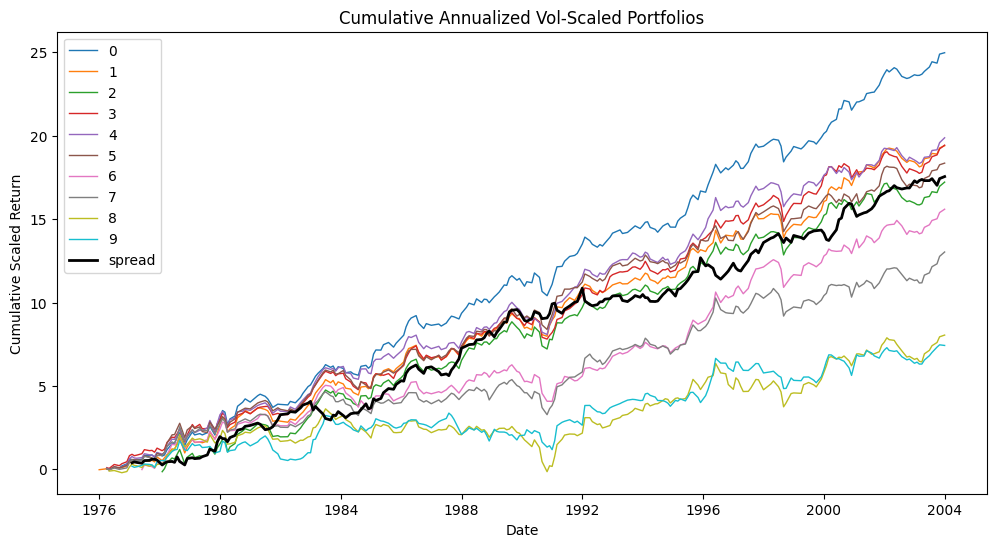

In [ ]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()


In [ ]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)


Sharpe ratios:
0    1.131378
1    0.918225
2    0.733052
3    0.815390
4    0.830521
5    0.685985
6    0.713969
7    0.545507
8    0.381971
9    0.382147
dtype: float32


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0049 (3.92),0.0045 (2.23),0.0007 (0.4),0.0011 (0.84),0.0002 (0.18),-0.0021 (-1.28),-0.0011 (-0.56),-0.004 (-1.77),-0.0065 (-2.32),-0.0028 (-0.53)
Mkt-RF,0.8472 (27.62),0.9343 (18.95),1.0087 (24.47),0.9554 (28.99),0.9684 (31.85),1.0428 (25.6),1.0984 (23.41),1.1499 (20.61),1.1759 (17.13),1.1492 (8.87)
SMB,0.6219 (16.05),0.697 (11.19),0.694 (13.31),0.544 (13.06),0.6364 (16.6),0.6935 (13.62),0.8487 (14.31),1.1747 (16.67),1.3179 (15.22),1.7522 (10.67)
HML,-0.0744 (-1.22),-0.1166 (-1.19),0.1197 (1.46),-0.0204 (-0.31),0.2231 (3.69),0.2736 (3.37),0.2901 (3.11),0.3937 (3.55),0.4719 (3.47),0.8519 (3.31)
RMW,0.3156 (6.19),0.2586 (3.16),0.0472 (0.69),-0.0622 (-1.13),0.0055 (0.11),0.0302 (0.45),0.0774 (0.99),0.0199 (0.21),-0.0599 (-0.53),-0.2651 (-1.23)
CMA,0.0723 (0.8),0.0168 (0.12),-0.0051 (-0.04),0.243 (2.5),0.0863 (0.96),0.1621 (1.36),0.1374 (0.99),0.2428 (1.47),0.1877 (0.93),-0.3358 (-0.89)


Monthly holding on failure in next 12 months

In [ ]:
bin_names=[str(i) for i in range(10)]

in_sample=in_sample.filter(pl.col('p_failure_12').is_not_null())


in_sample=in_sample.with_columns(
    (pl.col('p_failure_12').qcut(10,labels=bin_names)).alias('bin')
)

rets=in_sample.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')

for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)




# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_1401034/751388965.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_1401034/751388965.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


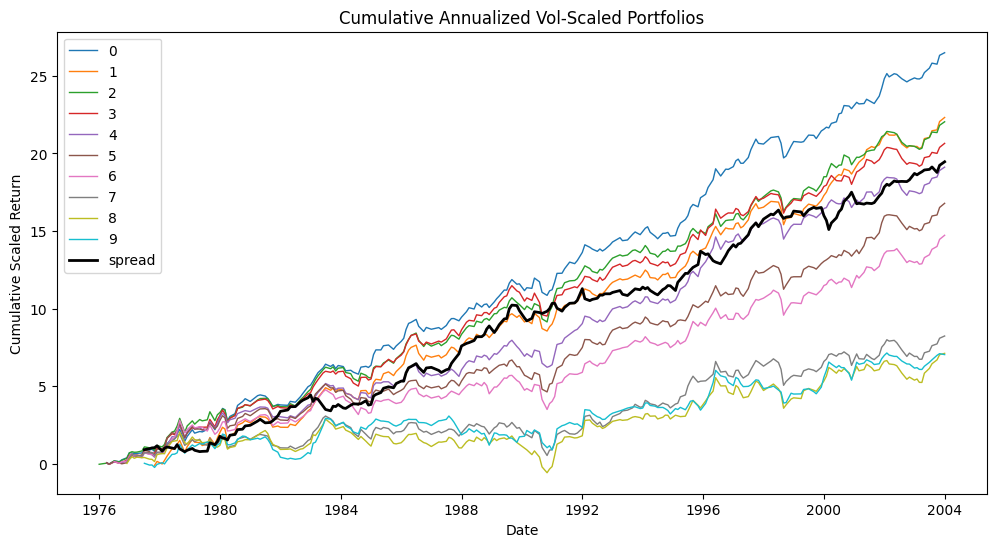

In [ ]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [ ]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)

# --- Average number of stocks per bin ---
n_stocks = (
    in_sample
    .group_by(["date","bin"])
    .agg(pl.count().alias("n"))
    .group_by("bin")
    .agg(pl.col("n").mean().alias("avg_n"))
    .sort("bin")
)

print("Average # of stocks per bin:")
print(n_stocks)


Sharpe ratios:
0    1.237414
1    0.959057
2    0.914575
3    0.832584
4    0.758336
5    0.697498
6    0.592685
7    0.316852
8    0.364539
9    0.403927
dtype: float32
Average # of stocks per bin:
shape: (10, 2)
┌─────┬────────────┐
│ bin ┆ avg_n      │
│ --- ┆ ---        │
│ cat ┆ f64        │
╞═════╪════════════╡
│ 0   ┆ 161.167247 │
│ 1   ┆ 164.024823 │
│ 2   ┆ 160.051903 │
│ 3   ┆ 160.607639 │
│ 4   ┆ 162.869718 │
│ 5   ┆ 162.869718 │
│ 6   ┆ 162.869718 │
│ 7   ┆ 166.384892 │
│ 8   ┆ 169.432234 │
│ 9   ┆ 164.024823 │
└─────┴────────────┘


/tmp/ipykernel_1401034/3645703563.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n"))


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0052 (3.73),0.0011 (0.8),0.0007 (0.48),0.0006 (0.39),-0.0007 (-0.5),-0.0022 (-1.35),-0.0035 (-1.72),-0.0092 (-4.05),-0.0073 (-2.18),-0.0014 (-0.25)
Mkt-RF,0.82 (24.19),0.9494 (28.88),0.9381 (25.96),0.9891 (26.13),1.0851 (29.92),1.0459 (26.1),1.191 (23.74),1.1736 (21.34),1.3608 (16.65),1.2216 (9.16)
SMB,0.4571 (10.67),0.5343 (12.74),0.6533 (14.46),0.7172 (15.01),0.7606 (16.6),0.8999 (17.77),0.9845 (15.46),1.1661 (16.81),1.4177 (13.72),1.7955 (10.63)
HML,-0.005 (-0.07),0.079 (1.21),0.1844 (2.57),0.2423 (3.22),0.2121 (2.94),0.3724 (4.68),0.3756 (3.76),0.4798 (4.38),0.6307 (3.88),0.8344 (3.15)
RMW,0.267 (4.74),0.2757 (5.04),0.1494 (2.49),0.2116 (3.36),0.224 (3.71),0.2374 (3.56),0.1757 (2.12),0.1166 (1.27),-0.2031 (-1.5),-0.4536 (-2.05)
CMA,0.1324 (1.32),0.2836 (2.91),0.1539 (1.45),-0.0027 (-0.02),0.0952 (0.89),0.0312 (0.26),0.178 (1.2),0.0033 (0.02),0.2857 (1.19),-0.4242 (-1.08)


Different Size Bins

In [ ]:
import polars as pl
import math

# keep only valid p_failure rows
in_sample = in_sample.filter(pl.col("p_failure").is_not_null())

# custom percentile cutpoints
probs = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 0.99]
qvals = (
    in_sample
    .select([pl.col("p_failure").quantile(p).alias(f"q{int(p*100)}") for p in probs])
).row(0)

# strictly increasing edges
edges = [-math.inf]
eps = 1e-12
for v in qvals:
    v = float(v)
    if v <= edges[-1]:
        v = edges[-1] + eps
    edges.append(v)
edges.append(math.inf)

bin_names = [
    "0-5","5-10","10-20","20-40","40-60",
    "60-80","80-90","90-95","95-99","99-100"
]

# assign bins via chained conditions (USE pl.lit for string outputs)
p = pl.col("p_failure")
expr = None
for i, label in enumerate(bin_names[:-1], start=1):  # up to the 9th edge
    cond = p <= edges[i]
    then_val = pl.lit(label)  # <- key fix
    expr = (pl.when(cond).then(then_val)) if expr is None else expr.when(cond).then(then_val)
expr = expr.otherwise(pl.lit(bin_names[-1]))

in_sample = in_sample.with_columns(expr.alias("bin"))


# --- 3) aggregate returns and cumulative series (your pipeline) ---
rets = (
    in_sample
    .group_by(["bin", "date"])
    .agg(pl.col("RET").mean())
    .sort(["bin", "date"])
    .pivot(index="date", on="bin", values="RET")
    .sort("date")
)

for b in bin_names:
    rets = rets.with_columns(pl.col(b).cum_sum().alias(f"{b}_cum"))


rets = rets.with_columns(
    (pl.col("0-5_cum") - pl.col("99-100_cum")).alias("spread_cum"),
    (pl.col("0-5") - pl.col("99-100")).alias("spread"),
)


In [ ]:

# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])

/tmp/ipykernel_1401034/1056077454.py:10: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_1401034/1056077454.py:16: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


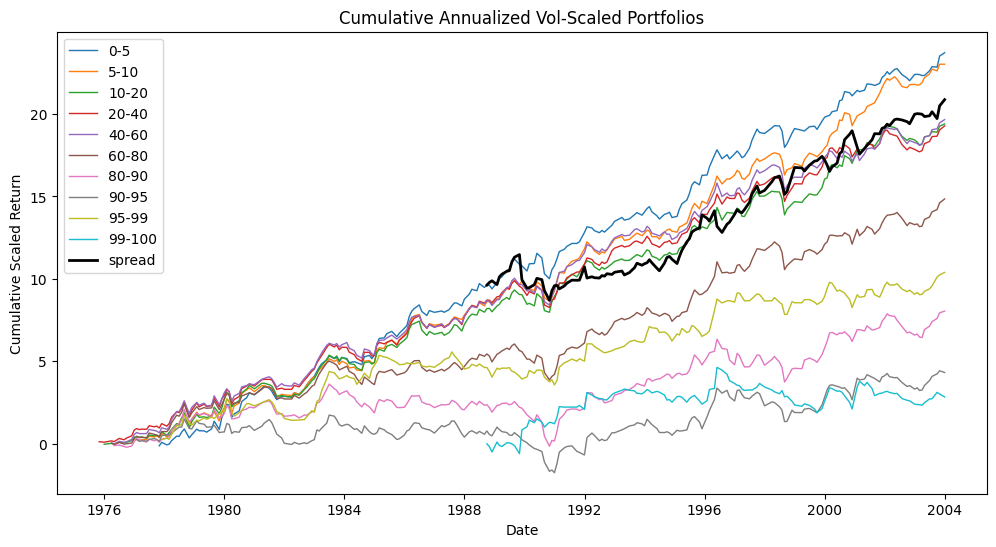

In [ ]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0-5_vol_scaled_ann_cum", "99-100_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0-5_vol_scaled_ann_cum"]-sub["99-100_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_w_spread if defined)
try:
    bin_w_spread = [c for c in bin_w_spread if c in M.columns]
except NameError:
    bin_w_spread = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_w_spread] = M[bin_w_spread].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_w_spread:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0-5,5-10,10-20,20-40,40-60,60-80,80-90,90-95,95-99,99-100,spread
const,0.0042 (2.01),0.0042 (2.66),0.0045 (2.23),0.0006 (0.55),-0.0011 (-0.81),-0.0028 (-1.47),-0.0065 (-2.32),-0.0056 (-1.03),0.0021 (0.36),0.0179 (1.03),-0.0213 (-1.21)
Mkt-RF,0.8732 (17.07),0.9015 (23.31),0.9343 (18.94),0.9827 (34.27),1.0096 (31.14),1.1145 (24.41),1.1759 (17.13),1.0894 (8.26),1.2073 (8.41),0.7513 (1.67),0.0668 (0.15)
SMB,0.6512 (9.97),0.6587 (13.47),0.6969 (11.19),0.5871 (16.2),0.6397 (15.81),1.0015 (17.36),1.3179 (15.22),1.5655 (9.36),1.7372 (9.5),2.933 (4.99),-2.214 (-3.74)
HML,0.2153 (2.11),-0.1946 (-2.53),-0.1167 (-1.19),0.0348 (0.61),0.243 (3.77),0.328 (3.61),0.4719 (3.47),0.7321 (2.79),0.8747 (3.08),1.3837 (1.57),-1.2626 (-1.42)
RMW,0.3511 (4.13),0.3136 (4.88),0.2588 (3.16),-0.0213 (-0.45),0.0059 (0.11),0.0492 (0.65),-0.0599 (-0.53),-0.1241 (-0.57),-0.2829 (-1.19),-0.9948 (-1.41),1.4802 (2.1)
CMA,-0.0662 (-0.44),0.1165 (1.02),0.0168 (0.12),0.1447 (1.71),0.162 (1.71),0.1684 (1.25),0.1877 (0.93),-0.354 (-0.91),-0.0599 (-0.14),-2.0464 (-1.69),1.8846 (1.54)


### Out of Sample

In [ ]:
start=dt.date(2004,1,1)
end=dt.date(2024,12,31)

out_of_sample=data.filter(pl.col('date').is_between(start,end))

In [ ]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -29.67,
 'tlmta_w': 3.36,
 'rsize_w': 0.082,
 'exretavg_w': -7.35,
 'sigma_w': 1.48,
 'cshmta_w': -2.40,
 'log_prc_w':-0.937,
 'mbq_w':.054
 }

b0_exact = -9.08

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in out_of_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
out_of_sample = out_of_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure")
)


In [ ]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -20.26,
 'tlmta_w': 1.42,
 'rsize_w': -0.045,
 'exretavg_w': -7.13,
 'sigma_w': 1.41,
 'cshmta_w': -2.13,
 'log_prc_w':-0.058,
 'mbq_w':.075
 }

b0_exact = -9.16

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in out_of_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
out_of_sample = out_of_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure_12")
)


#### Portfolio Formation

In [ ]:
ff5=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5.csv')

# ff5["date"] is like 196307 → make it the last calendar day of that month
ff5 = ff5.with_columns(
    (
        pl.concat_str([pl.col("date").cast(pl.Utf8), pl.lit("01")])  # "19630701"
        .str.strptime(pl.Date, format="%Y%m%d")                        # 1963-07-01
        .dt.offset_by("1mo")                                        # 1963-08-01
        .dt.replace(day=1)                                          # 1963-08-01 (idempotent)
        - pl.duration(days=1)                                       # 1963-07-31
    ).alias("date")
)



Monthly Rebalance (Equal Weight)

In [ ]:
bin_names=[str(i) for i in range(10)]

decile1=out_of_sample.filter(pl.col('p_failure').is_not_null())


decile1=decile1.with_columns(
    (pl.col('p_failure').qcut(10,labels=bin_names)).alias('bin')
    
)

rets=decile1.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')


for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)


# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_1401034/147306125.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_1401034/147306125.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


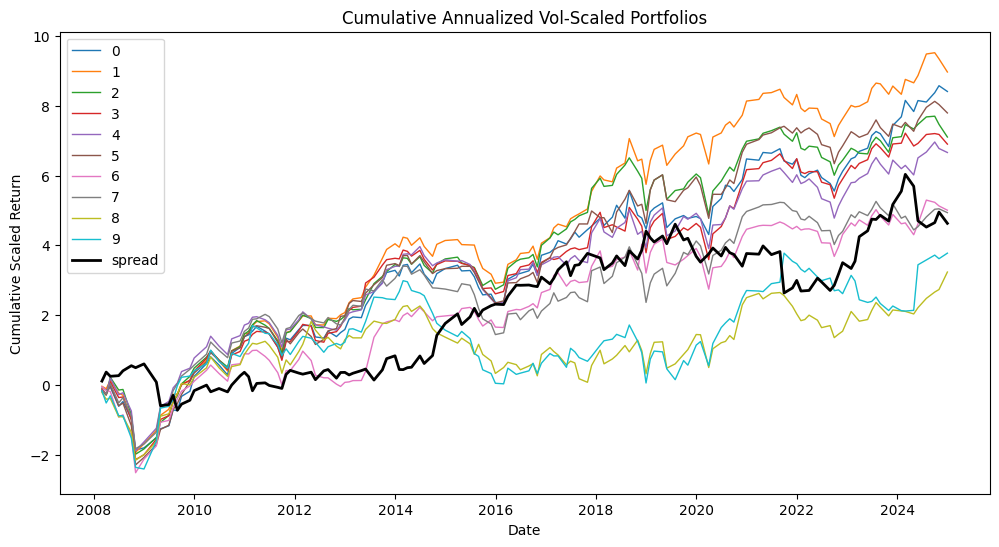

In [ ]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()


In [ ]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)


Sharpe ratios:
0    0.743478
1    0.760572
2    0.634863
3    0.611011
4    0.597851
5    0.679999
6    0.445942
7    0.411395
8    0.311551
9    0.350820
dtype: float32


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0022 (1.39),0.002 (1.48),0.0002 (0.16),0.0001 (0.06),-0.0006 (-0.34),0.0018 (0.97),-0.0021 (-0.93),-0.0017 (-0.61),-0.0017 (-0.39),0.0029 (0.31)
Mkt-RF,0.7662 (20.1),0.8725 (27.04),0.908 (30.63),0.9611 (27.92),0.9953 (24.51),1.0168 (23.2),1.1029 (19.76),1.0673 (16.11),1.1079 (10.25),1.5065 (6.55)
SMB,0.4033 (5.99),0.5718 (10.03),0.4255 (8.13),0.403 (6.63),0.4616 (6.44),0.5084 (6.57),0.551 (5.59),0.6003 (5.13),0.7406 (3.88),1.2885 (3.17)
HML,-0.2218 (-3.32),-0.1278 (-2.26),0.0095 (0.18),0.022 (0.37),0.0353 (0.5),0.1192 (1.55),0.3176 (3.25),0.1913 (1.65),0.1951 (1.03),0.4946 (1.23)
RMW,-0.1308 (-1.55),0.0592 (0.83),-0.0641 (-0.98),-0.1142 (-1.5),0.089 (0.99),-0.0852 (-0.88),-0.0413 (-0.33),-0.2316 (-1.58),-0.4574 (-1.91),-0.6428 (-1.26)
CMA,0.0706 (0.65),-0.0296 (-0.32),-0.0442 (-0.53),-0.0393 (-0.4),-0.0917 (-0.8),0.0373 (0.3),-0.1374 (-0.87),-0.0439 (-0.23),0.1139 (0.37),-0.5739 (-0.88)


Monthly holding on failure in next 12 months

In [ ]:
bin_names=[str(i) for i in range(10)]

out_of_sample=out_of_sample.filter(pl.col('p_failure_12').is_not_null())


out_of_sample=out_of_sample.with_columns(
    (pl.col('p_failure_12').qcut(10,labels=bin_names)).alias('bin')
)

rets=out_of_sample.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')

for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)




# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_1401034/3593363874.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_1401034/3593363874.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


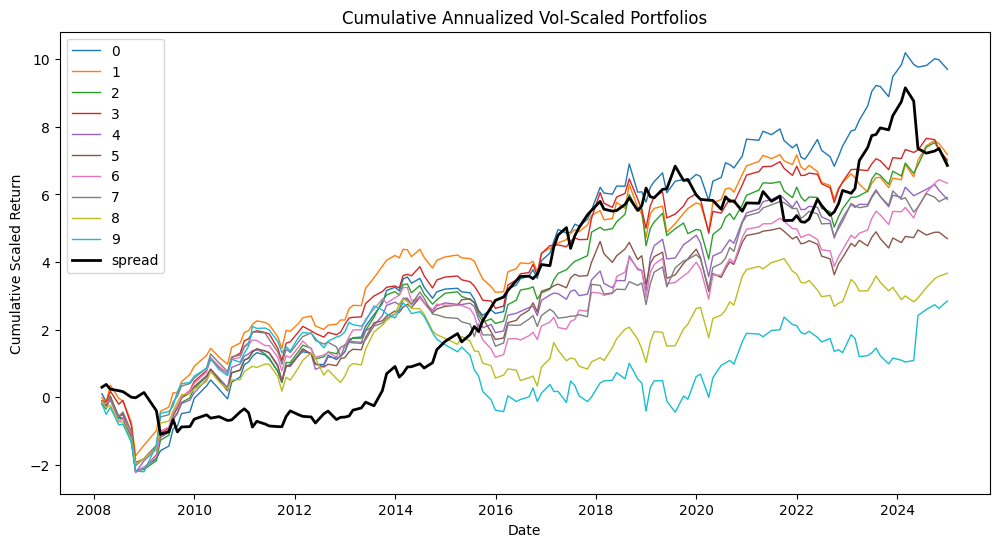

In [ ]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [ ]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)

# --- Average number of stocks per bin ---
n_stocks = (
    in_sample
    .group_by(["date","bin"])
    .agg(pl.count().alias("n"))
    .group_by("bin")
    .agg(pl.col("n").mean().alias("avg_n"))
    .sort("bin")
)

print("Average # of stocks per bin:")
print(n_stocks)


Sharpe ratios:
0    0.823610
1    0.647431
2    0.670800
3    0.589629
4    0.511432
5    0.443813
6    0.604979
7    0.414920
8    0.327805
9    0.313393
dtype: float32
Average # of stocks per bin:
shape: (10, 2)
┌────────┬────────────┐
│ bin    ┆ avg_n      │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ 0-5    ┆ 83.494585  │
│ 10-20  ┆ 161.730769 │
│ 20-40  ┆ 317.90378  │
│ 40-60  ┆ 307.33887  │
│ 5-10   ┆ 82.30605   │
│ 60-80  ┆ 319.0      │
│ 80-90  ┆ 168.2      │
│ 90-95  ┆ 85.343173  │
│ 95-99  ┆ 69.037313  │
│ 99-100 ┆ 20.927602  │
└────────┴────────────┘


/tmp/ipykernel_1401034/3645703563.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n"))


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0032 (1.93),0.0002 (0.14),0.0004 (0.31),-0.0005 (-0.38),-0.0014 (-0.94),-0.0023 (-1.28),0.001 (0.46),-0.0016 (-0.56),-0.0012 (-0.29),-0.0002 (-0.02)
Mkt-RF,0.7888 (19.76),0.8802 (25.08),0.8743 (25.91),0.9384 (27.03),0.996 (28.12),1.0389 (23.66),1.0437 (20.69),1.0323 (15.05),1.1338 (11.25),1.4962 (7.6)
SMB,0.2244 (3.18),0.5211 (8.41),0.4107 (6.89),0.4663 (7.61),0.4193 (6.7),0.3927 (5.06),0.4777 (5.36),0.7317 (6.04),0.8429 (4.74),1.2659 (3.64)
HML,-0.105 (-1.5),-0.0372 (-0.61),-0.0027 (-0.05),0.0716 (1.18),0.0824 (1.33),0.1751 (2.28),0.123 (1.39),0.2075 (1.73),0.1458 (0.83),0.35 (1.02)
RMW,-0.2144 (-2.42),0.0934 (1.2),0.0405 (0.54),0.0279 (0.36),-0.1217 (-1.55),-0.1291 (-1.33),-0.1771 (-1.58),-0.1187 (-0.78),-0.5738 (-2.57),-0.5621 (-1.29)
CMA,-0.0143 (-0.13),0.0129 (0.13),-0.0235 (-0.25),0.0023 (0.02),-0.0172 (-0.17),0.0201 (0.16),-0.1811 (-1.27),-0.067 (-0.35),-0.0119 (-0.04),-0.5149 (-0.92)


Different Size Bins

In [ ]:
import polars as pl
import math

# keep only valid p_failure rows
out_of_sample = out_of_sample.filter(pl.col("p_failure").is_not_null())

# custom percentile cutpoints
probs = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 0.99]
qvals = (
    out_of_sample
    .select([pl.col("p_failure").quantile(p).alias(f"q{int(p*100)}") for p in probs])
).row(0)

# strictly increasing edges
edges = [-math.inf]
eps = 1e-12
for v in qvals:
    v = float(v)
    if v <= edges[-1]:
        v = edges[-1] + eps
    edges.append(v)
edges.append(math.inf)

bin_names = [
    "0-5","5-10","10-20","20-40","40-60",
    "60-80","80-90","90-95","95-99","99-100"
]

# assign bins via chained conditions (USE pl.lit for string outputs)
p = pl.col("p_failure")
expr = None
for i, label in enumerate(bin_names[:-1], start=1):  # up to the 9th edge
    cond = p <= edges[i]
    then_val = pl.lit(label)  # <- key fix
    expr = (pl.when(cond).then(then_val)) if expr is None else expr.when(cond).then(then_val)
expr = expr.otherwise(pl.lit(bin_names[-1]))

out_of_sample = out_of_sample.with_columns(expr.alias("bin"))


# --- 3) aggregate returns and cumulative series (your pipeline) ---
rets = (
    out_of_sample
    .group_by(["bin", "date"])
    .agg(pl.col("RET").mean())
    .sort(["bin", "date"])
    .pivot(index="date", on="bin", values="RET")
    .sort("date")
)

for b in bin_names:
    rets = rets.with_columns(pl.col(b).cum_sum().alias(f"{b}_cum"))


rets = rets.with_columns(
    (pl.col("0-5_cum") - pl.col("99-100_cum")).alias("spread_cum"),
    (pl.col("0-5") - pl.col("99-100")).alias("spread"),
)


In [ ]:

# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])

/tmp/ipykernel_1401034/1056077454.py:10: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_1401034/1056077454.py:16: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


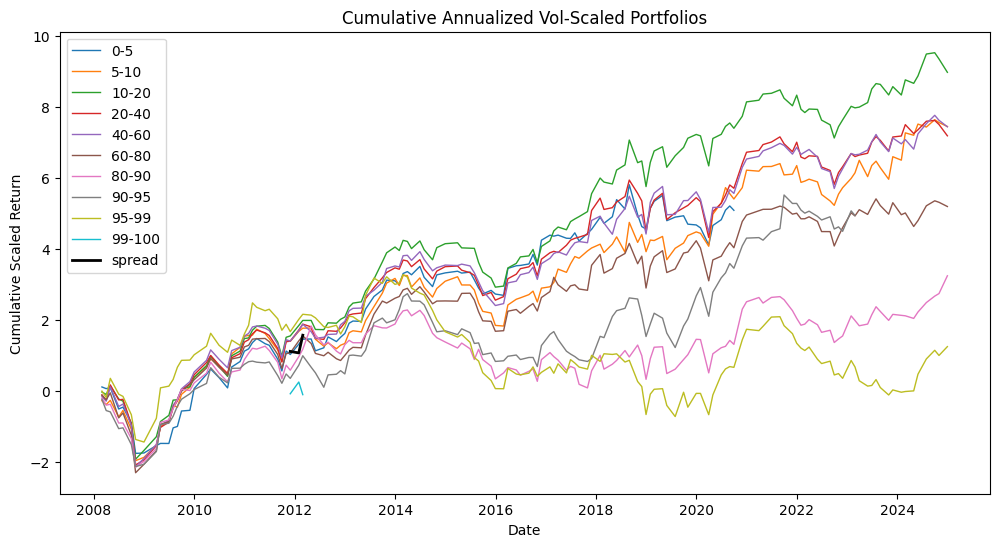

In [ ]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0-5_vol_scaled_ann_cum", "99-100_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0-5_vol_scaled_ann_cum"]-sub["99-100_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_w_spread if defined)
try:
    bin_w_spread = [c for c in bin_w_spread if c in M.columns]
except NameError:
    bin_w_spread = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_w_spread] = M[bin_w_spread].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_w_spread:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0-5,5-10,10-20,20-40,40-60,60-80,80-90,90-95,95-99,99-100,spread
const,0.0038 (1.93),0.0011 (0.57),0.002 (1.48),0.0001 (0.12),0.0004 (0.3),-0.0023 (-1.22),-0.0017 (-0.39),0.0068 (0.93),-0.0102 (-1.21),0.137 (0.75),-0.1358 (-0.74)
Mkt-RF,0.7204 (14.97),0.8274 (16.95),0.8726 (27.04),0.9371 (35.57),0.9995 (28.01),1.093 (23.94),1.1079 (10.25),1.1927 (6.73),1.6483 (8.13),2.9049 (0.67),-2.2468 (-0.51)
SMB,0.41 (4.84),0.4334 (5.03),0.5718 (10.03),0.4117 (8.85),0.4823 (7.65),0.5474 (6.79),0.7406 (3.88),0.9192 (2.93),1.4288 (3.99),4.2607 (0.55),-3.8563 (-0.49)
HML,-0.1588 (-1.9),-0.3149 (-3.68),-0.1278 (-2.26),0.0063 (0.14),0.0795 (1.27),0.2658 (3.32),0.1951 (1.03),0.08 (0.26),0.3875 (1.09),4.7896 (0.64),-4.9682 (-0.66)
RMW,-0.1884 (-1.78),-0.1043 (-0.96),0.0592 (0.83),-0.0798 (-1.37),0.0136 (0.17),-0.1422 (-1.4),-0.4574 (-1.91),-0.8641 (-2.22),-0.8131 (-1.81),8.6441 (0.91),-8.8368 (-0.93)
CMA,-0.0705 (-0.52),0.2857 (2.07),-0.0296 (-0.32),-0.037 (-0.5),-0.0356 (-0.35),-0.0866 (-0.67),0.1139 (0.37),0.2906 (0.59),-0.3381 (-0.59),-16.7191 (-1.37),16.6163 (1.35)


### MVO backtest

In [ ]:
start=dt.date(2004,1,1)
end=dt.date(2024,12,31)

barra_data=sfd.assets.load_assets(start=start,end=end,in_universe=True,columns=['date','historical_beta','ticker','price','return','barrid','cusip','specific_return','specific_risk','market_cap','total_risk','predicted_beta'])
barra_data=barra_data.rename({'cusip':'CUSIP'})
barra_data = barra_data.with_columns(
    pl.col("CUSIP").str.slice(0, 8).alias("CUSIP")
)


Merge out_of_sample with barra_data

In [ ]:
out=out_of_sample.join(barra_data,on=['date','CUSIP'])

Make the alphas

In [ ]:
#score the signal

out=out.with_columns(
    (((pl.col('p_failure'))-(pl.col('p_failure').mean()))/(pl.col('p_failure').std()*-1))
    .alias('p_failure_score')
)

out=out.with_columns(
    (((pl.col('p_failure_12'))-(pl.col('p_failure_12').mean()))/(pl.col('p_failure_12').std()*-1))
    .alias('p_failure_12_score')
)

In [ ]:
IC=.05

out=out.with_columns(
    ((pl.col('p_failure_score'))*IC*(pl.col('specific_risk')/100)).alias('1_y_alpha')
)

out=out.with_columns(
    ((pl.col('p_failure_12_score'))*IC*(pl.col('specific_risk')/100)).alias('1_mo_alpha')
)




In [ ]:
out['1_mo_alpha'].min()

-1.626343662982124

In [ ]:
out

PERMNO,date,SHRCD,EXCHCD,CUSIP,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,RETX,NCUSIP,TICKER,DLAMT,DLPDT,DLSTCD,DLRETX,DLPRC,DLRET,costat,curcdq,datafmt,indfmt,consol,gvkey,cusip,atq,cheq,ltq,niq,pstkrq,seqq,txditcq,LINKTYPE,LPERMCO,LINKDT,…,cshmta,nita,tlta,sigma,exretavg,nimtaavg,prc_winsor,log_prc,nita_w,tlta_w,exret_w,sigma_w,rsize_w,log_prc_w,nimtaavg_w,exretavg_w,mbq_w,tlmta_w,cshmta_w,failure,p_failure,p_failure_12,bin,historical_beta,ticker,price,return,barrid,specific_return,specific_risk,market_cap,total_risk,predicted_beta,p_failure_score,p_failure_12_score,1_y_alpha,1_mo_alpha
i64,date,i64,i64,str,f64,f64,f64,i64,f32,i64,str,str,str,f64,str,i64,str,f64,f32,str,str,str,str,str,i64,str,f64,f64,f64,f64,f64,f64,f64,str,i64,str,…,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,i8,f64,f64,str,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
13878,2014-06-30,11,3,"""60249610""",5.41,7.09,7.09,193712,0.296161,105330,"""0.296161""","""60249610""","""MDXG""",null,null,null,null,null,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",86.025,39.245,11.536,-0.39,0.0,74.489,0.0,"""LC""",54378,"""2013-04-25""",…,null,-0.003562,0.512295,0.404319,-0.002055,-0.00068,7.09,1.958685,-0.003562,0.512295,0.204061,0.404319,-10.089976,1.958685,-0.00068,-0.002055,null,0.41041,null,0,0.00006,0.000986,"""40-60""",1.617313,"""MDXG""",7.09,2.1614,"""USA06Z1""",1.727,50.739435,7.4002584e8,57.880263,1.594899,0.100084,-0.171397,0.002539,-0.004348
13878,2014-09-30,11,3,"""60249610""",6.92,7.4,7.13,88409,0.012784,106890,"""0.012784""","""60249610""","""MDXG""",null,null,null,null,null,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",97.317,47.253,16.061,3.699,0.0,81.256,0.0,"""LC""",54378,"""2020-11-04""",…,0.050726,-0.00252,0.074527,0.447868,0.046031,-0.000733,7.13,1.964311,-0.00252,0.259034,0.028339,0.447868,-10.072969,1.964311,-0.000733,0.046031,10.231386,0.149518,0.050726,0,0.000029,0.000472,"""20-40""",1.744037,"""MDXG""",7.13,-3.6486,"""USA06Z1""",-1.285,46.019938,7.5518108e8,52.965269,1.53652,0.137253,0.228422,0.003158,0.005256
13878,2014-09-30,11,3,"""60249610""",6.92,7.4,7.13,88409,0.012784,106890,"""0.012784""","""60249610""","""MDXG""",null,null,null,null,null,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",97.317,47.253,16.061,3.699,0.0,81.256,0.0,"""LC""",54378,"""2013-04-25""",…,null,-0.005168,0.516001,0.447868,0.048563,-0.000692,7.13,1.964311,-0.005168,0.516001,0.028339,0.447868,-10.072969,1.964311,-0.000692,0.048563,null,0.426562,null,0,0.000028,0.000485,"""20-40""",1.744037,"""MDXG""",7.13,-3.6486,"""USA06Z1""",-1.285,46.019938,7.5518108e8,52.965269,1.53652,0.137538,0.218234,0.003165,0.005022
13878,2014-12-31,11,3,"""60249610""",10.65,11.87,11.53,166980,0.042495,107790,"""0.042495""","""60249610""","""MDXG""",null,null,null,null,null,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",109.259,52.332,19.93,3.833,0.0,89.329,0.0,"""LC""",54378,"""2020-11-04""",…,0.037536,0.017328,0.075237,0.494091,0.102535,-0.0001,11.53,2.444952,0.017328,0.259034,0.045815,0.494091,-9.626749,2.444952,-0.0001,0.067823,15.295101,0.149518,0.037536,0,0.000028,0.000662,"""20-40""",1.179103,"""MDXG""",11.53,3.9675,"""USA06Z1""",3.54,43.099579,1.2191e9,49.433359,1.090224,0.13813,0.080343,0.002977,0.001731
13878,2014-12-31,11,3,"""60249610""",10.65,11.87,11.53,166980,0.042495,107790,"""0.042495""","""60249610""","""MDXG""",null,null,null,null,null,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",109.259,52.332,19.93,3.833,0.0,89.329,0.0,"""LC""",54378,"""2013-04-25""",…,null,-0.00688,0.518278,0.494091,0.087282,0.000525,11.53,2.444952,-0.00688,0.518278,0.045815,0.494091,-9.626749,2.444952,0.000525,0.067823,null,0.429514,null,0,0.000023,0.000627,"""20-40""",1.179103,"""MDXG""",11.53,3.9675,"""USA06Z1""",3.54,43.099579,1.2191e9,49.433359,1.090224,0.144246,0.107927,0.003108,0.002326
13878,2015-03-31,11,3,"""60249610""",

In [ ]:
#get rid of out duplicates
out_dedup = out.unique(subset=["barrid", "date"], keep="first")


In [ ]:
alpha1m=out_dedup.filter(pl.col('1_mo_alpha').is_not_null())
alpha1y=out_dedup.filter(pl.col('1_y_alpha').is_not_null())
alpha1m=alpha1m.select(['date','barrid','1_mo_alpha','predicted_beta'])
alpha1y=alpha1y.select(['date','barrid','1_y_alpha','predicted_beta'])

alpha1m=alpha1m.rename({'1_mo_alpha':'alpha'})
alpha1y=alpha1y.rename({'1_y_alpha':'alpha'})

In [ ]:
mkt_cap=out.select(['market_cap','barrid','date','rsize','meq','totval'])
mkt_cap=mkt_cap.with_columns(
    (((pl.col('market_cap')/1000)*13)/pl.col('totval')).alias('signal_weight')
)



In [ ]:
alpha1m_vw=alpha1m.join(mkt_cap,on=['barrid','date'])
alpha1m_vw=alpha1m_vw.with_columns(
    ((pl.col('alpha'))*pl.col('signal_weight')).alias('alpha')
)

alpha1m_vw = alpha1m_vw.unique(subset=["barrid", "date"], keep="first")
alpha1m_vw=alpha1m_vw.select(['date','barrid','alpha','predicted_beta'])

In [ ]:
alpha1y_vw=alpha1y.join(mkt_cap,on=['barrid','date'])
alpha1y_vw=alpha1y_vw.with_columns(
    ((pl.col('alpha'))*pl.col('signal_weight')).alias('alpha')
)

alpha1y_vw = alpha1y_vw.unique(subset=["barrid", "date"], keep="first")
alpha1y_vw=alpha1y_vw.select(['date','barrid','alpha','predicted_beta'])

**Do the backests**

1 month alpha

In [ ]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment()]
# ,sfo.LongOnly()


month_alpha_bt=sfb.backtest_parallel(alpha1m,constraints=constraints,gamma=5,n_cpus=10)

2025-09-26 21:40:49,644	INFO worker.py:1951 -- Started a local Ray instance.
(pid=1416319) Computing portfolios with 10 cpus 0: 100%|██████████| 177/177 [01:13<00:00, 2.42it/s] 


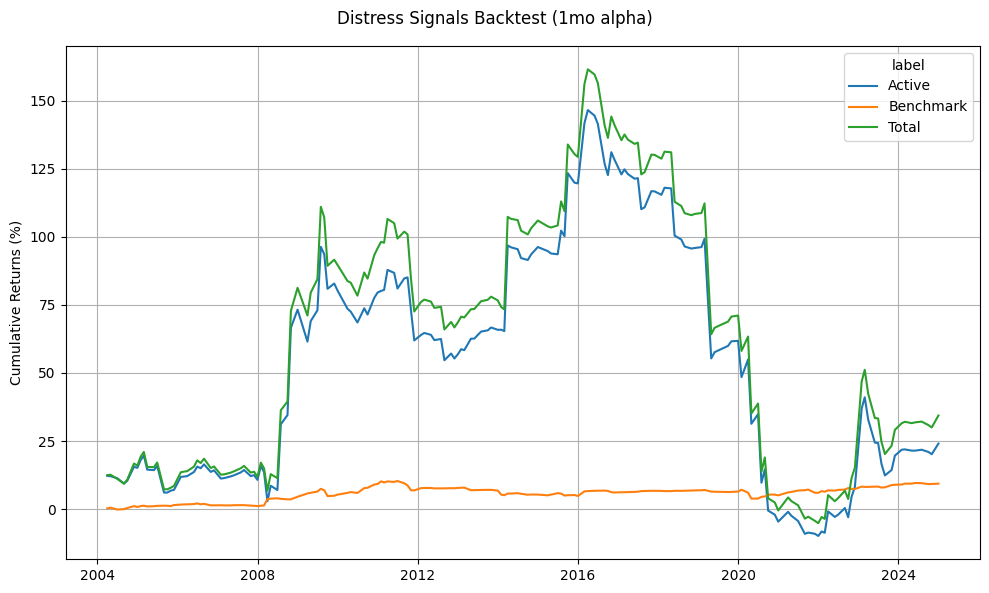

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,67.88,87.46,24.04,0.78
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,80.91,89.37,34.37,0.91


In [ ]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [ ]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,0.0027 (0.64),-0.0008 (-1.85),0.0033 (0.76)
Mkt-RF,-0.2356 (-2.32),-0.0028 (-0.28),-0.2402 (-2.31)
SMB,0.3033 (1.69),0.0097 (0.55),0.3078 (1.68)
HML,0.0079 (0.04),0.0155 (0.89),0.0258 (0.14)
RMW,0.2189 (0.97),-0.0083 (-0.38),0.2117 (0.92)
CMA,0.3851 (1.34),-0.0115 (-0.41),0.3575 (1.22)


1 year alpha

In [ ]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment() ,sfo.LongOnly()]



year_alpha_bt=sfb.backtest_parallel(alpha1y,constraints=constraints,gamma=3,n_cpus=10)

2025-09-26 22:12:12,775	INFO worker.py:1951 -- Started a local Ray instance.





























































































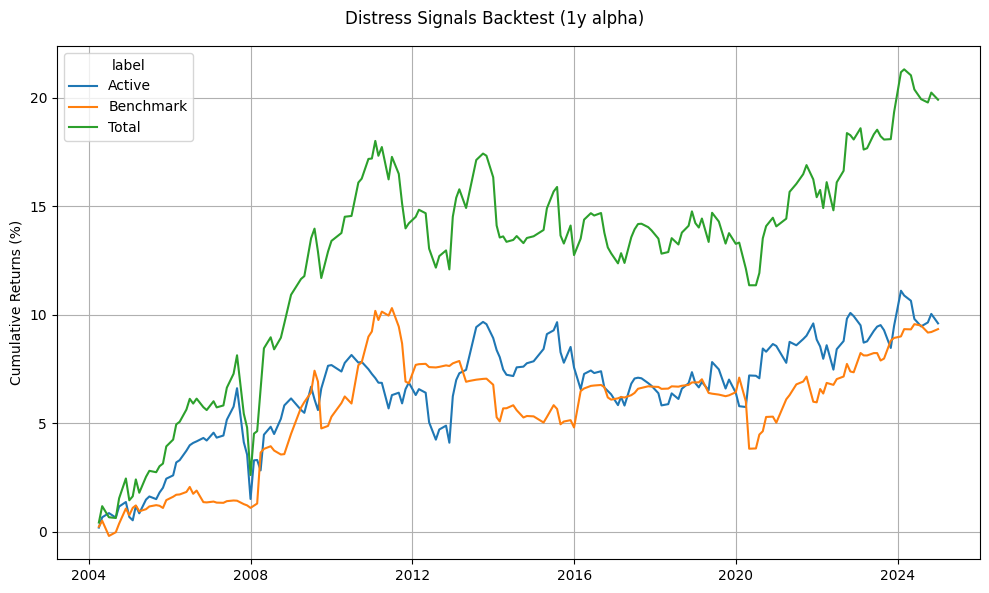

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,13.53,9.71,9.6,1.39
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,26.56,11.85,19.91,2.24


In [ ]:
year_port_rets=sfp.generate_returns_from_weights(year_alpha_bt)

sfp.generate_returns_chart(year_port_rets,title='Distress Signals Backtest (1y alpha)')
sum_stats=sfp.generate_summary_table(year_port_rets)
sum_stats

In [ ]:
month_ret_ff=year_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.72),-0.0008 (-1.85),-0.0003 (-0.47)
Mkt-RF,0.0117 (0.98),-0.0028 (-0.28),0.0071 (0.5)
SMB,0.0075 (0.36),0.0097 (0.55),0.0119 (0.47)
HML,-0.0101 (-0.48),0.0155 (0.89),0.0078 (0.31)
RMW,-0.0127 (-0.48),-0.0083 (-0.38),-0.02 (-0.63)
CMA,-0.0162 (-0.48),-0.0115 (-0.41),-0.0438 (-1.08)


1 month alpha (value weighted)

In [ ]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment()]
# ,sfo.LongOnly()


month_alpha_bt_vw=sfb.backtest_parallel(alpha1m_vw,constraints=constraints,gamma=5,n_cpus=10)

2025-09-26 08:43:39,727	INFO worker.py:1951 -- Started a local Ray instance.







































































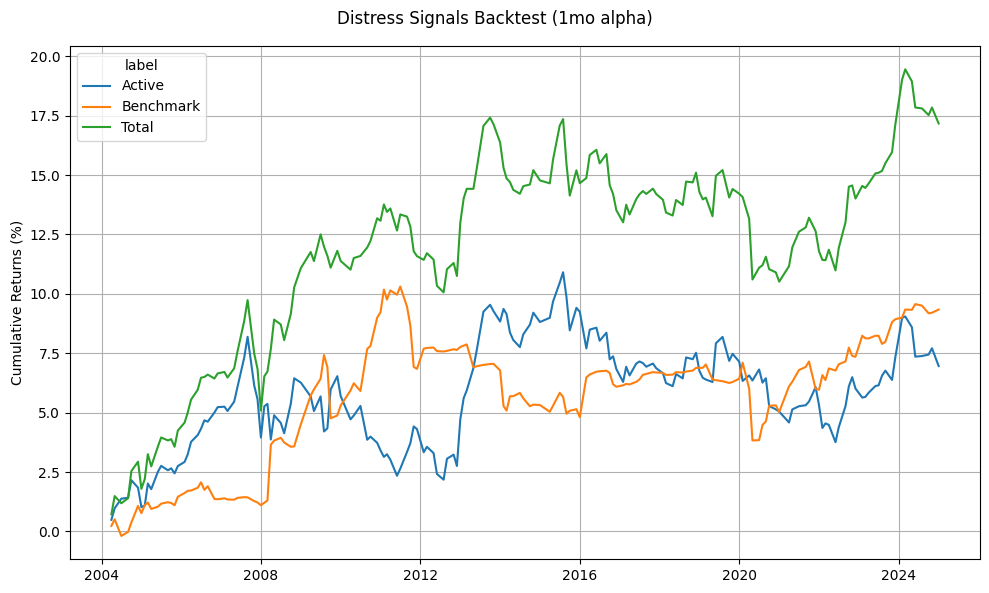

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,10.1,10.14,6.96,1.0
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,23.13,10.6,17.17,2.18


In [ ]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt_vw)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [ ]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0007 (-1.43),-0.0008 (-1.85),-0.0002 (-0.3)
Mkt-RF,-0.008 (-0.66),-0.0028 (-0.28),-0.0125 (-1.0)
SMB,-0.0039 (-0.18),0.0097 (0.55),0.0005 (0.02)
HML,0.0018 (0.08),0.0155 (0.89),0.0196 (0.89)
RMW,-0.0449 (-1.67),-0.0083 (-0.38),-0.0521 (-1.87)
CMA,-0.0302 (-0.88),-0.0115 (-0.41),-0.0578 (-1.63)


Yearly VW

In [ ]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment(),sfo.LongOnly()]
# ,sfo.LongOnly()


month_alpha_bt_vw=sfb.backtest_parallel(alpha1y_vw,constraints=constraints,gamma=1,n_cpus=10)

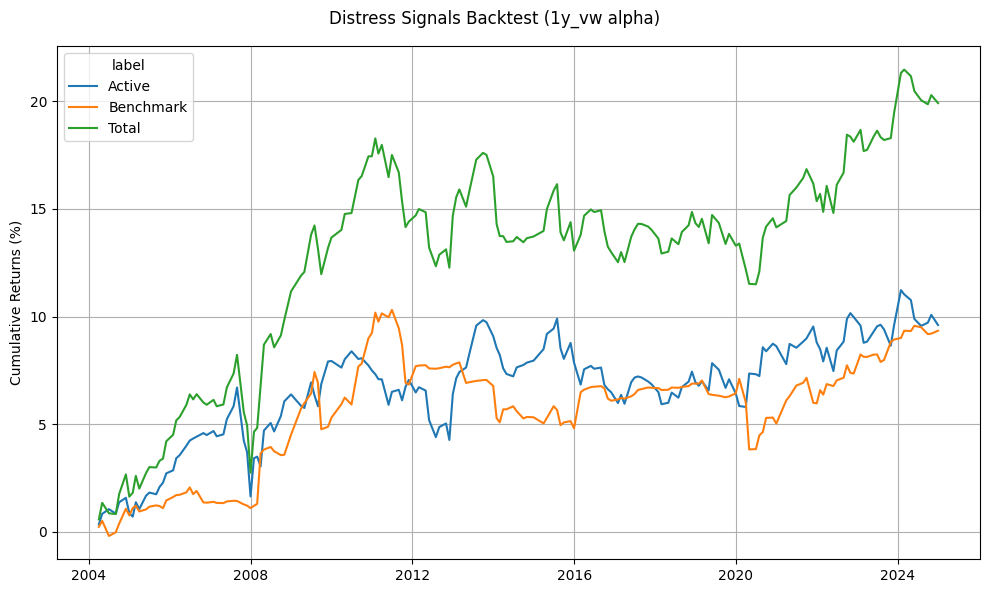

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,13.53,9.71,9.6,1.39
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,26.56,11.83,19.91,2.24


In [ ]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt_vw)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1y_vw alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [ ]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.71),-0.0008 (-1.85),-0.0003 (-0.47)
Mkt-RF,0.011 (0.93),-0.0028 (-0.28),0.0065 (0.45)
SMB,0.0075 (0.36),0.0097 (0.55),0.012 (0.47)
HML,-0.0097 (-0.47),0.0155 (0.89),0.0082 (0.33)
RMW,-0.0114 (-0.43),-0.0083 (-0.38),-0.0187 (-0.59)
CMA,-0.0182 (-0.54),-0.0115 (-0.41),-0.0458 (-1.13)


## In progress code

In [ ]:
# #chats null filling code

# base_sparse = ["mbq", "tlmta", "cshmta"]

# targets = []
# for c in base_sparse:
#     if c in data.columns:
#         targets.append(c)
#     elif f"{c}_w" in data.columns:
#         targets.append(f"{c}_w")

# if targets:
#     # 1) cross-sectional means by month for each target
#     cs_means = (
#         data.group_by("date")
#             .agg([pl.col(c).mean().alias(f"{c}__cs") for c in targets])
#     )
#     data = data.join(cs_means, on="date", how="left")

#     # 2) fill missing with same-month CS mean
#     data = data.with_columns([
#         pl.coalesce([pl.col(c), pl.col(f"{c}__cs")]).alias(c)
#         for c in targets
#     ]).drop([f"{c}__cs" for c in targets])

#     # 3) pooled fallback in case an entire month had no data
#     pooled = data.select(
#         [pl.col(c).mean().alias(f"{c}__pool") for c in targets]
#     ).to_dicts()[0]

#     for c in targets:
#         pool = pooled[f"{c}__pool"]
#         data = data.with_columns(
#             pl.coalesce([pl.col(c), pl.lit(float(pool) if pool is not None else 0.0)])
#               .alias(c)
#         )

#     # sanity check
#     print(
#         data.select(
#             pl.len().alias("rows"),
#             *[pl.col(c).is_null().sum().alias(f"null_{c}") for c in targets]
#         )
#     )
# else:
#     print("No target columns (mbq/tlmta/cshmta or their *_w versions) found in `data`.")


shape: (1, 4)
┌─────────┬──────────┬────────────┬─────────────┐
│ rows    ┆ null_mbq ┆ null_tlmta ┆ null_cshmta │
│ ---     ┆ ---      ┆ ---        ┆ ---         │
│ u32     ┆ u32      ┆ u32        ┆ u32         │
╞═════════╪══════════╪════════════╪═════════════╡
│ 2561893 ┆ 0        ┆ 0          ┆ 0           │
└─────────┴──────────┴────────────┴─────────────┘


$$
NIMTAAVG_{t-1,t-12} = \frac{1 - \phi^3}{1 - \phi^{12}} 
\left( NIMTA_{t-1,t-3} + \cdots + \phi^9 NIMTA_{t-10,t-12} \right),
$$

$$
EXRETAVG_{t-1,t-12} = \frac{1 - \phi}{1 - \phi^{12}}
\left( EXRET_{t-1} + \cdots + \phi^{11} EXRET_{t-12} \right),
$$

where $\phi = 2^{-\tfrac{1}{3}}$

When lagged excess returns or profitability are missing, we replace them with their crosssectional means in order to avoid losing observations. 


In [ ]:
# #this was chat's code but I am pretty sure this is right

# phi = 2 ** (-1/3)  # weights halve each quarter

# # 0) sort
# data = data.sort(["PERMNO", "date"])

# # 1) build within-firm lags 1..12 for nimta & exret
# lag_exprs = []
# for col in ["nimta", "exret"]:
#     lag_exprs += [
#         pl.col(col).shift(k).over("PERMNO").alias(f"{col}_lag{k}")
#         for k in range(1, 13)
#     ]
# data = data.with_columns(lag_exprs)

# # 2) cross-sectional (by-date) means for nimta & exret
# means = (
#     data.group_by("date")
#         .agg(
#             nimta_mean = pl.col("nimta").mean(),
#             exret_mean = pl.col("exret").mean()
#         )
# )

# # 3) for each k, attach the *date-(k months)* cross-sectional mean,
# #    and use it to fill missing lags
# for k in range(1, 13):
#     # key to look up mean at t-k
#     mean_k = means.rename({"date": f"date_k{k}"})

#     # add a date-(k months) column to main frame
#     data = data.with_columns(
#         pl.col("date").dt.offset_by(f"-{k}mo").alias(f"date_k{k}")
#     )

#     # join in the CS mean for that lag month
#     data = data.join(
#         mean_k,
#         left_on=f"date_k{k}",
#         right_on=f"date_k{k}",
#         how="left",
#     )

#     # fill missing lags with that cross-sectional mean for the lag month
#     data = data.with_columns([
#         pl.when(pl.col(f"nimta_lag{k}").is_null())
#           .then(pl.col("nimta_mean"))
#           .otherwise(pl.col(f"nimta_lag{k}"))
#           .alias(f"nimta_lag{k}_f"),

#         pl.when(pl.col(f"exret_lag{k}").is_null())
#           .then(pl.col("exret_mean"))
#           .otherwise(pl.col(f"exret_lag{k}"))
#           .alias(f"exret_lag{k}_f"),
#     ])

#     # (optional) drop helper columns to keep frame tidy
#     data = data.drop([f"date_k{k}", "nimta_mean", "exret_mean"])

# # 4) NIMTAAVG_{t-1,t-12}  (3-month block averages with φ^0, φ^3, φ^6, φ^9)
# avg1 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(1, 4)])    # t-1..t-3
# avg2 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(4, 7)])    # t-4..t-6
# avg3 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(7, 10)])   # t-7..t-9
# avg4 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(10, 13)])  # t-10..t-12

# nimtaavg = ((1 - phi**3) / (1 - phi**12)) * (
#     avg1 + (phi**3) * avg2 + (phi**6) * avg3 + (phi**9) * avg4
# )

# data = data.with_columns(nimtaavg.alias("nimtaavg"))

# # 5) EXRETAVG_{t-1,t-12}  (monthly EW average with φ^{0..11})
# weights = [phi**(k-1) for k in range(1, 13)]
# weighted_sum = pl.sum_horizontal(
#     [pl.col(f"exret_lag{k}_f") * weights[k-1] for k in range(1, 13)]
# )
# exretavg = ((1 - phi) / (1 - phi**12)) * weighted_sum

# data = data.with_columns(exretavg.alias("exretavg"))


In [ ]:
# phi = 2 ** (-1/3)  # weights halve each quarter

# # --- 0) canonical monthly index so joins are exact ----------------------------
# # assumes `date` is a proper datetime (month-end or month-start is fine)
# data = data.with_columns([
#     (pl.col("date").dt.year() * 12 + pl.col("date").dt.month()).alias("mon_idx")
# ])

# # --- 1) within-firm lags (raw nimta & exret) ---------------------------------
# lag_exprs = []
# for col in ["nimta", "exret"]:
#     lag_exprs += [
#         pl.col(col).shift(k).over("PERMNO").alias(f"{col}_lag{k}")
#         for k in range(1, 13)
#     ]
# data = data.with_columns(lag_exprs)

# # --- 2) cross-sectional means by month (at time t) ---------------------------
# means = (
#     data.group_by("mon_idx")
#         .agg(
#             nimta_mean_t = pl.col("nimta").mean(),
#             exret_mean_t = pl.col("exret").mean()
#         )
# )

# # --- 3) for each k, fetch the cross-sectional mean at (t-k) using mon_idx ----
# for k in range(1, 13):
#     # the month index we want for this lag
#     data = data.with_columns(
#         (pl.col("mon_idx") - k).alias(f"mon_idx_k{k}")
#     )

#     # attach means for (t-k) by joining on mon_idx_k{k}
#     data = data.join(
#         means.rename({"mon_idx": f"mon_idx_k{k}",
#                       "nimta_mean_t": f"nimta_mean_k{k}",
#                       "exret_mean_t": f"exret_mean_k{k}"}),
#         on=f"mon_idx_k{k}",
#         how="left",
#     )

#     # fill missing lags with *that month’s* cross-sectional mean (t-k)
#     data = data.with_columns([
#         pl.when(pl.col(f"nimta_lag{k}").is_null())
#           .then(pl.col(f"nimta_mean_k{k}"))
#           .otherwise(pl.col(f"nimta_lag{k}"))
#           .alias(f"nimta_lag{k}_f"),

#         pl.when(pl.col(f"exret_lag{k}").is_null())
#           .then(pl.col(f"exret_mean_k{k}"))
#           .otherwise(pl.col(f"exret_lag{k}"))
#           .alias(f"exret_lag{k}_f"),
#     ])

#     # (optional) drop helpers to keep tidy; keep _f columns
#     data = data.drop([f"mon_idx_k{k}", f"nimta_mean_k{k}", f"exret_mean_k{k}"])

# # --- 4) NIMTAAVG_{t-1..t-12} (3-mo blocks with φ^{0,3,6,9}) ------------------
# avg1 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(1, 4)])    # t-1..t-3
# avg2 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(4, 7)])    # t-4..t-6
# avg3 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(7, 10)])   # t-7..t-9
# avg4 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(10, 13)])  # t-10..t-12

# nimtaavg = ((1 - phi**3) / (1 - phi**12)) * (
#     avg1 + (phi**3) * avg2 + (phi**6) * avg3 + (phi**9) * avg4
# )
# data = data.with_columns(nimtaavg.alias("nimtaavg"))

# # --- 5) EXRETAVG_{t-1..t-12} (EW with φ^{0..11}) -----------------------------
# weights = [phi**(k-1) for k in range(1, 13)]
# weighted_sum = pl.sum_horizontal(
#     [pl.col(f"exret_lag{k}_f") * weights[k-1] for k in range(1, 13)]
# )
# exretavg = ((1 - phi) / (1 - phi**12)) * weighted_sum
# data = data.with_columns(exretavg.alias("exretavg"))

# # --- 6) quick sanity check: almost-zero nulls except sample start -------------
# null_check = data.select(
#     *[pl.col(f"nimta_lag{k}_f").is_null().sum().alias(f"null_nimta_lag{k}_f") for k in range(1,13)],
#     *[pl.col(f"exret_lag{k}_f").is_null().sum().alias(f"null_exret_lag{k}_f") for k in range(1,13)],
#     pl.col("nimtaavg").is_null().sum().alias("null_nimtaavg"),
#     pl.col("exretavg").is_null().sum().alias("null_exretavg"),
# )
# null_check

In [ ]:

# # exret should already be log(1+RET) - log(1+MKT)
# phi = 2 ** (-1/3)  # weights halve each quarter

# # 0) Exact monthly index for clean (t - k) joins
# data = data.with_columns(
#     (pl.col("date").dt.year() * 12 + pl.col("date").dt.month()).alias("mon_idx")
# )

# # 1) Within-firm lags 1..12 for nimta & exret
# lag_exprs = []
# for col in ["nimta", "exret"]:
#     lag_exprs += [
#         pl.col(col).shift(k).over("PERMNO").alias(f"{col}_lag{k}")
#         for k in range(1, 13)
#     ]
# data = data.with_columns(lag_exprs)

# # 2) Cross-sectional means at time t (by mon_idx)
# means_t = (
#     data.group_by("mon_idx")
#         .agg(
#             nimta_mean_t = pl.col("nimta").mean(),
#             exret_mean_t = pl.col("exret").mean()
#         )
# )

# # 3) For each k, attach means for (t - k) and fill lag nulls with that month’s mean
# for k in range(1, 13):
#     # month index for the lag month
#     data = data.with_columns((pl.col("mon_idx") - k).alias(f"mon_idx_k{k}"))

#     # bring in CS means for (t - k)
#     data = data.join(
#         means_t.rename({
#             "mon_idx": f"mon_idx_k{k}",
#             "nimta_mean_t": f"nimta_mean_k{k}",
#             "exret_mean_t": f"exret_mean_k{k}",
#         }),
#         on=f"mon_idx_k{k}",
#         how="left",
#     )

#     # fill missing lags with CS mean at (t - k)
#     data = data.with_columns([
#         pl.when(pl.col(f"nimta_lag{k}").is_null())
#           .then(pl.col(f"nimta_mean_k{k}"))
#           .otherwise(pl.col(f"nimta_lag{k}"))
#           .alias(f"nimta_lag{k}_f"),

#         pl.when(pl.col(f"exret_lag{k}").is_null())
#           .then(pl.col(f"exret_mean_k{k}"))
#           .otherwise(pl.col(f"exret_lag{k}"))
#           .alias(f"exret_lag{k}_f"),
#     ])

#     # tidy helpers
#     data = data.drop([f"mon_idx_k{k}", f"nimta_mean_k{k}", f"exret_mean_k{k}"])

# # 4) Fallback: if some lag is still null (e.g., CS mean itself missing), use pooled mean, then 0
# pooled = data.select(
#     pl.col("nimta").mean().alias("nimta_pool_mean"),
#     pl.col("exret").mean().alias("exret_pool_mean"),
# ).to_dicts()[0]
# nimta_pool = pooled["nimta_pool_mean"] if pooled["nimta_pool_mean"] is not None else 0.0
# exret_pool = pooled["exret_pool_mean"] if pooled["exret_pool_mean"] is not None else 0.0

# for k in range(1, 13):
#     data = data.with_columns([
#         pl.coalesce([pl.col(f"nimta_lag{k}_f"), pl.lit(nimta_pool), pl.lit(0.0)]).alias(f"nimta_lag{k}_f"),
#         pl.coalesce([pl.col(f"exret_lag{k}_f"), pl.lit(exret_pool), pl.lit(0.0)]).alias(f"exret_lag{k}_f"),
#     ])

# # 5) NIMTAAVG_{t-1..t-12} (3-month block average with φ^{0,3,6,9})
# avg1 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(1, 4)])    # t-1..t-3
# avg2 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(4, 7)])    # t-4..t-6
# avg3 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(7, 10)])   # t-7..t-9
# avg4 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(10, 13)])  # t-10..t-12

# nimtaavg = ((1 - phi**3) / (1 - phi**12)) * (
#     avg1 + (phi**3) * avg2 + (phi**6) * avg3 + (phi**9) * avg4
# )

# # 6) EXRETAVG_{t-1..t-12} (EW with φ^{0..11})
# weights = [phi**(k-1) for k in range(1, 13)]
# weighted_sum = pl.sum_horizontal([
#     pl.col(f"exret_lag{k}_f") * weights[k-1] for k in range(1, 13)
# ])
# exretavg = ((1 - phi) / (1 - phi**12)) * weighted_sum

# data = data.with_columns([
#     nimtaavg.alias("nimtaavg"),
#     exretavg.alias("exretavg"),
# ])

# # 7) Sanity check: should be ~0 except very early months
# print(
#     data.select(
#         *[pl.col(f"nimta_lag{k}_f").is_null().sum().alias(f"null_nimta_lag{k}_f") for k in range(1,13)],
#         *[pl.col(f"exret_lag{k}_f").is_null().sum().alias(f"null_exret_lag{k}_f") for k in range(1,13)],
#         pl.col("nimtaavg").is_null().sum().alias("null_nimtaavg"),
#         pl.col("exretavg").is_null().sum().alias("null_exretavg"),
#     )
# )


In [ ]:
# import polars as pl

# phi = 2 ** (-1/3)  # weights halve each quarter

# # Work lazily so Polars can optimize
# df = data.lazy()

# # 0) Month index (int for faster joins)
# df = df.with_columns(
#     (pl.col("date").dt.year() * 12 + pl.col("date").dt.month())
#     .cast(pl.Int32)
#     .alias("mon_idx")
# )

# # 1) Cross-sectional means at time t (by mon_idx)
# means_t = (
#     df.group_by("mon_idx")
#       .agg(
#           nimta_mean_t = pl.col("nimta").mean(),
#           exret_mean_t = pl.col("exret").mean(),
#       )
# )

# # 2) Build ONE long lag table for k=1..12
# #    Keep both the join key at t (mon_idx_join) and the source lag month (mon_idx_src = t-k)
# base = df.select(["PERMNO", "mon_idx", "nimta", "exret"])
# lag_long = pl.concat([
#     base.with_columns([
#         pl.lit(k).alias("k"),
#         (pl.col("mon_idx") + k).alias("mon_idx_join"),  # to match rows at t
#         pl.col("mon_idx").alias("mon_idx_src"),         # original month, i.e., t-k
#     ]).rename({
#         "nimta": "nimta_val",
#         "exret": "exret_val",
#     })
#     for k in range(1, 13)
# ]).lazy()

# # 3) Join once to attach all k-lags (firm values from t-k) to rows at t
# joined = df.join(
#     lag_long,
#     left_on=["PERMNO", "mon_idx"],
#     right_on=["PERMNO", "mon_idx_join"],
#     how="left",
# )

# # 4) Bring in cross-sectional means for the *lag month* (t-k) via mon_idx_src
# joined = joined.join(
#     means_t,
#     left_on="mon_idx_src",
#     right_on="mon_idx",
#     how="left",
# ).drop("mon_idx_right")  # from the join; keep the left mon_idx

# # 5) Fill missing lag values with that lag month’s CS mean (no pooled fallback)
# joined = joined.with_columns([
#     pl.coalesce([pl.col("nimta_val"), pl.col("nimta_mean_t")]).alias("nimta_filled"),
#     pl.coalesce([pl.col("exret_val"), pl.col("exret_mean_t")]).alias("exret_filled"),
# ])

# # 6) Go wide without pivot(): groupby and pick the value for each k
# nimta_wide = joined.group_by(["PERMNO", "mon_idx"]).agg(
#     [pl.col("nimta_filled").filter(pl.col("k") == k).first().alias(f"nimta_lag{k}_f")
#      for k in range(1, 13)]
# )
# exret_wide = joined.group_by(["PERMNO", "mon_idx"]).agg(
#     [pl.col("exret_filled").filter(pl.col("k") == k).first().alias(f"exret_lag{k}_f")
#      for k in range(1, 13)]
# )

# # 7) Rejoin lag blocks back to the base rows
# df = (
#     df.join(nimta_wide, on=["PERMNO", "mon_idx"], how="left")
#       .join(exret_wide, on=["PERMNO", "mon_idx"], how="left")
# )

# # 8) Build the averages
# avg1 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(1, 4)])     # t-1..t-3
# avg2 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(4, 7)])     # t-4..t-6
# avg3 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(7, 10)])    # t-7..t-9
# avg4 = pl.mean_horizontal([pl.col(f"nimta_lag{k}_f") for k in range(10, 13)])   # t-10..t-12

# nimtaavg_expr = ((1 - phi**3) / (1 - phi**12)) * (
#     avg1 + (phi**3) * avg2 + (phi**6) * avg3 + (phi**9) * avg4
# )

# weights = [phi**(k-1) for k in range(1, 13)]
# exretavg_expr = ((1 - phi) / (1 - phi**12)) * pl.sum_horizontal(
#     [pl.col(f"exret_lag{k}_f") * weights[k-1] for k in range(1, 13)]
# )

# df = df.with_columns([
#     nimtaavg_expr.alias("nimtaavg"),
#     exretavg_expr.alias("exretavg"),
# ])

# # 9) Materialize
# data = df.collect()

# # (Optional) quick null check
# print(
#     data.select(
#         *[pl.col(f"nimta_lag{k}_f").is_null().sum().alias(f"null_nimta_lag{k}_f") for k in range(1, 13)],
#         *[pl.col(f"exret_lag{k}_f").is_null().sum().alias(f"null_exret_lag{k}_f") for k in range(1, 13)],
#         pl.col("nimtaavg").is_null().sum().alias("null_nimtaavg"),
#         pl.col("exretavg").is_null().sum().alias("null_exretavg"),
#     )
# )


shape: (1, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ null_nimt ┆ null_nimt ┆ null_nimt ┆ null_nimt ┆ … ┆ null_exre ┆ null_exre ┆ null_nimt ┆ null_exr │
│ a_lag1_f  ┆ a_lag2_f  ┆ a_lag3_f  ┆ a_lag4_f  ┆   ┆ t_lag11_f ┆ t_lag12_f ┆ aavg      ┆ etavg    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ u32       ┆ u32       ┆ u32       ┆ u32       ┆   ┆ u32       ┆ u32       ┆ u32       ┆ u32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1057992   ┆ 1011358   ┆ 530449    ┆ 1031369   ┆ … ┆ 859457    ┆ 819277    ┆ 253061    ┆ 0        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘


In [ ]:
#winsorize the price
data = data.with_columns(
    pl.when(pl.col("PRC") > 15)
      .then(15)
      .otherwise(pl.col("PRC"))
      .alias("prc_winsor")
)

#log it
data = data.with_columns(
    pl.col("prc_winsor").log().alias("log_prc")
)


"In order to further limit the influence of outliers, including those firms whose
book equity has been adjusted as above, we winsorize the market-to-book ratio
and all other variables in our model at the 5th and 95th percentiles of their
pooled distributions across all firm-months. That is, we replace any observation
below the 5th percentile with the 5th percentile, and any observation above the
95th percentile with the 95th percentile."

In [ ]:
# Variables to winsorize
vars_to_winsor = [
    "mbq",        # Market-to-Book
    "nimtaavg",
    "tlmta",
    "cshmta",
    "rsize",
    "exretavg",
    "sigma",
    "log_prc",
]

# 1. Clean infinities -> null so they don't pollute quantiles
data = data.with_columns([
    pl.when(pl.col(c).is_infinite())
      .then(None)
      .otherwise(pl.col(c))
      .alias(c)
    for c in vars_to_winsor
])

# 2. Compute pooled 5% / 95% cutoffs
qdf = data.select(
    *[pl.col(c).quantile(0.05).alias(f"{c}_lo") for c in vars_to_winsor],
    *[pl.col(c).quantile(0.95).alias(f"{c}_hi") for c in vars_to_winsor],
).to_dicts()[0]

# 3. Apply winsorization; keep originals, add *_w columns
for c in vars_to_winsor:
    lo = qdf[f"{c}_lo"]
    hi = qdf[f"{c}_hi"]
    data = data.with_columns(
        pl.when(pl.col(c) < lo).then(lo)
         .when(pl.col(c) > hi).then(hi)
         .otherwise(pl.col(c))
         .alias(f"{c}_w")
    )

# After this, use *_w columns in the model:
# mbq_w, nimtaavg_w, tlmta_w, cshmta_w, rsize_w, exretavg_w, sigma_w, log_prc_w


    "mbq",          
    "nimtaavg",
    "tlmta",
    "cshmta",
    "rsize",
    "exretavg",
    "sigma",
    "log_prc",

    699_118 - mbq_w
    2_561_893 - nimtaavg_w
    739_971 - tlmta_w
    735_712 - cshmta_w
    2_483_325 - rsize_w
    2_181_612 - exretavg_w
    2_559_403 - sigma_w
    2_483_399 - log_prc_w
    
    
    
    

    

#### Logisitic Regression

In [ ]:
import statsmodels.api as sm

# --- define in-sample period ---
start = pl.date(1965, 1, 1)   # Jan 1965
end   = pl.date(2003, 12, 31) # Dec 2003

# filter in Polars
in_sample = data.filter(
    (pl.col("date") >= start) & (pl.col("date") <= end)
)

# choose predictors
predictors = [
    "nimtaavg_w",
    "tlmta_w",
    "cshmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    "log_prc_w",
    "mbq_w",  
]

# drop rows with missing data in predictors or failure
reg_data = in_sample.select(["failure"] + predictors).drop_nulls().to_pandas()

X = reg_data[predictors]
y = reg_data["failure"]

# add constant (intercept)
X = sm.add_constant(X)

# fit logit model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.001046
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:              1224634
Model:                          Logit   Df Residuals:                  1224625
Method:                           MLE   Df Model:                            8
Date:                Sat, 20 Sep 2025   Pseudo R-squ.:                  0.2332
Time:                        17:15:24   Log-Likelihood:                -1281.4
converged:                       True   LL-Null:                       -1671.1
Covariance Type:            nonrobust   LLR p-value:                5.470e-163
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.8085      2.204     -9.441      0.000     -25.128     -16.489
nimtaavg_w   -38.1556      7

In [ ]:
insample_vars = [
    "mbq_w",
    "nimtaavg_w",
    "tlmta_w",
    "cshmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    "log_prc_w",
    "failure"
]

# select those columns and describe
desc = data.select(insample_vars).describe()

desc

statistic,mbq_w,nimtaavg_w,tlmta_w,cshmta_w,rsize_w,exretavg_w,sigma_w,log_prc_w,failure
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.113539e6,2.308832e6,2.561893e6,2.561893e6,2.483325e6,2.477834e6,2.559403e6,2.483399e6,2.561893e6
"""null_count""",448354.0,253061.0,0.0,0.0,78568.0,84059.0,2490.0,78494.0,0.0
"""mean""",2.595331,-0.001425,0.459793,0.094222,-10.406154,-0.004943,0.517981,2.052299,0.001813
"""std""",1.700863,0.010594,0.171082,0.046979,1.936851,0.034518,0.302758,0.871789,0.042542
"""min""",0.219315,-0.027256,0.128681,0.011719,-13.650849,-0.081898,0.160525,-0.083382,0.0
"""25%""",1.291917,-0.00582,0.380871,0.072954,-11.893857,-0.023364,0.290345,1.578979,0.0
"""50%""",2.335609,-0.000493,0.435839,0.091193,-10.520089,-0.001789,0.435146,2.545531,0.0
"""75%""",3.344956,0.005466,0.539183,0.109334,-9.013639,0.016508,0.659425,2.70805,0.0
"""max""",7.220968,0.014086,0.884938,0.217781,-6.72478,0.057827,1.287601,2.70805,1.0


In [ ]:
keep_cols = [
    # identifiers
    "PERMNO", "TICKER",
    
    # time
    "date",
    
    # CRSP stock info
    "PRC", "SHROUT", "RET", "RETX", "VOL",'SHRCD',
    
    # Delisting info
    "DLSTCD", "DLRET", "DLRETX",
    
    # Compustat fundamentals (quarterly)
    "atq", "cheq", "cshoq", "ltq", "niq", "seqq",
    
    # S&P500 benchmark
    "totval", "sprtrn"
]

#out of sample is 2004 to 2024
out_of_sample=data.filter(pl.col('date')>(dt.date(2003,12,31))).sort(['date','PERMNO'])


#in sample will be 1965-2003
data=data.filter(pl.col('date')<(dt.date(2004,1,1))).sort(['date','PERMNO'])


df = data.select(keep_cols)



ColumnNotFoundError: unable to find column "cshoq"; valid columns: ["PERMNO", "date", "SHRCD", "EXCHCD", "CUSIP", "BIDLO", "ASKHI", "PRC", "VOL", "RET", "SHROUT", "RETX", "NCUSIP", "TICKER", "DLAMT", "DLPDT", "DLSTCD", "DLRETX", "DLPRC", "DLRET", "costat", "curcdq", "datafmt", "indfmt", "consol", "gvkey", "cusip", "atq", "cheq", "ltq", "niq", "pstkrq", "seqq", "txditcq", "LINKTYPE", "LPERMCO", "LINKDT", "LINKENDDT", "tic", "caldt", "totval", "totcnt", "usdval", "spindx", "sprtrn", "caldt_date", "beq", "meq", "taq_adjusted", "mbq", "rsize", "exret", "nimta", "tlmta", "cshmta", "nimta_lag1", "nimta_lag2", "nimta_lag3", "nimta_lag4", "nimta_lag5", "nimta_lag6", "nimta_lag7", "nimta_lag8", "nimta_lag9", "nimta_lag10", "nimta_lag11", "nimta_lag12", "exret_lag1", "exret_lag2", "exret_lag3", "exret_lag4", "exret_lag5", "exret_lag6", "exret_lag7", "exret_lag8", "exret_lag9", "exret_lag10", "exret_lag11", "exret_lag12", "nimta_lag1_f", "exret_lag1_f", "nimta_lag2_f", "exret_lag2_f", "nimta_lag3_f", "exret_lag3_f", "nimta_lag4_f", "exret_lag4_f", "nimta_lag5_f", "exret_lag5_f", "nimta_lag6_f", "exret_lag6_f", "nimta_lag7_f", "exret_lag7_f", "nimta_lag8_f", "exret_lag8_f", "nimta_lag9_f", "exret_lag9_f", "nimta_lag10_f", "exret_lag10_f", "nimta_lag11_f", "exret_lag11_f", "nimta_lag12_f", "exret_lag12_f", "nimtaavg", "exretavg", "prc_winsor", "log_prc", "sigma", "mbq_w", "nimtaavg_w", "tlmta_w", "cshmta_w", "rsize_w", "exretavg_w", "sigma_w", "log_prc_w", "failure", "mon_idx", "sigma_right"]

In [ ]:
# 0) Ensure proper dtypes up front
num_cols = [
    "PRC","SHROUT","RET","RETX","DLRET","DLRETX",
    "atq","cheq","cshoq","ltq","niq","seqq",
    "totval","sprtrn"
]
df = df.with_columns([pl.col(c).cast(pl.Float64, strict=False) for c in num_cols])
df = df.with_columns(pl.col("date").cast(pl.Date, strict=False))

# 1) Basics: abs price, mktcap
df = df.with_columns([
    pl.col("PRC").abs().alias("prc_abs"),
    (pl.col("PRC").abs() * pl.col("SHROUT") * 1000).alias("mktcap"),
])

# 2) RSIZE and EXRET need S&P fields; EXRET uses RETX
df = df.with_columns([
    (pl.col("mktcap") / (pl.col("totval")*pl.lit(1000))).log().alias("RSIZE"),
    (pl.col("RETX") - pl.col("sprtrn")).alias("exret"),
])

# 3) Delisting-adjusted portfolio return
df = df.with_columns(
    ((1 + pl.col("RET")).fill_null(1.0) * (1 + pl.col("DLRET")).fill_null(1.0) - 1)
    .alias("RET_adj")
)

# 4) Market-assets denominator & book equity floor
df = df.with_columns([
    (pl.col("ltq") + pl.col("mktcap")).alias("mkt_assets"),
    pl.when(pl.col("seqq") <= 0).then(pl.lit(1.0)).otherwise(pl.col("seqq")).alias("seqq_pos"),
])

# 5) Failure flags
df = df.with_columns([
    (pl.col("DLSTCD") == 574).cast(pl.Int8).alias("BANKRUPT"),
    pl.col("DLSTCD").is_between(500, 599).cast(pl.Int8).alias("FAILURE"),
])

# 6) Ratios (accounting-based; will lag later)
df = df.with_columns([
    (pl.col("niq") / pl.col("mkt_assets")).alias("NIMTA"),
    (pl.col("ltq") / pl.col("mkt_assets")).alias("TLMTA"),
    (pl.col("cheq") / pl.col("mkt_assets")).alias("CASHMTA"),
    (pl.col("mktcap") / pl.col("seqq_pos")).alias("MB"),
    pl.col("prc_abs").clip(15.0).log().alias("PRICE"),
])

# 7) Lag accounting-based vars by 2 months within PERMNO
acc_cols = ["NIMTA","TLMTA","CASHMTA","MB"]
df = df.sort(["PERMNO","date"]).with_columns([
    pl.col(c).shift(2).over("PERMNO").alias(c) for c in acc_cols
])

# 8) Geometrically-weighted 12-month averages (λ=2/3)
λ = 2/3
weights = [λ**k for k in range(12)]
norm = (1-λ) / (1-λ**12)

def decayed_avg(colname: str, outname: str):
    exprs = [
        (pl.col(colname).fill_null(0.0).shift(k).over("PERMNO") * w)
        for k, w in enumerate(weights)
    ]
    return (pl.sum_horizontal(exprs) * norm).alias(outname)

df = df.with_columns([
    decayed_avg("NIMTA", "NIMTAAVG"),
    decayed_avg("exret", "EXRETAVG"),
])


# 7. Merge into your monthly df
df = df.join(sigma_m, on=["PERMNO","date"], how="left")


In [ ]:
preds = ["NIMTAAVG","TLMTA","EXRETAVG","SIGMA","RSIZE","CASHMTA","MB","PRICE"]

# 1) make quantiles (one row per date, no conflicts yet)
qtiles = (
    df.group_by("date")
      .agg([pl.col(c).quantile(0.05).alias(f"{c}_p5") for c in preds] +
           [pl.col(c).quantile(0.95).alias(f"{c}_p95") for c in preds])
)

# 2) drop any old quantile cols in df (from previous runs)
qt_cols = [f"{c}_p5" for c in preds] + [f"{c}_p95" for c in preds]
df = df.drop([c for c in qt_cols if c in df.columns])

# 3) join (no suffix needed now)
df = df.join(qtiles, on="date", how="left")

# 4) clip using the expected names
for c in preds:
    df = df.with_columns(
        pl.col(c).clip(
            lower_bound=pl.col(f"{c}_p5"),
            upper_bound=pl.col(f"{c}_p95")
        ).alias(c)
    )

# 5) tidy up
df = df.drop(qt_cols)


In [ ]:
keep_cols = [
    "PERMNO","TICKER","date",
    "PRC","SHROUT","RET","RETX","VOL","RET_adj",
    "DLSTCD","DLRET","DLRETX","BANKRUPT","FAILURE",
    "atq","cheq","cshoq","ltq","niq","seqq",
    "totval","sprtrn",
    "prc_abs","mktcap","mkt_assets","seqq_pos",
    "RSIZE","exret",
    "NIMTA","TLMTA","CASHMTA","MB","PRICE",
    "NIMTAAVG","EXRETAVG","SIGMA",'SHRCD'
]

df = df.select([c for c in keep_cols if c in df.columns])


In [ ]:
# --- CHS logit with standardized predictors (no sampling) ---

import polars as pl
import numpy as np
import statsmodels.api as sm

X_cols = ["NIMTAAVG","TLMTA","EXRETAVG","SIGMA","RSIZE","CASHMTA","MB","PRICE"]
DV = "FAILURE"  # or "BANKRUPT"

# 0) standardize predictors (winsorize first, then standardize)
for c in X_cols:
    # compute mean/std as scalars
    mu = df.select(pl.col(c).mean()).item()
    sd = df.select(pl.col(c).std()).item()
    if sd is None or sd == 0:
        sd = 1.0  # avoid divide-by-zero; leaves column centered only
    df = df.with_columns(((pl.col(c) - mu) / sd).alias(f"{c}_std"))

X_std = [f"{c}_std" for c in X_cols]

# 1) lead DV by 1 month within PERMNO
df = df.sort(["PERMNO","date"]).with_columns(
    pl.col(DV).shift(-1).over("PERMNO").alias(f"{DV}_lead1")
)

# 2) build clean table (use standardized columns)
df = df.with_row_count("row_id")
cols_needed = ["row_id", f"{DV}_lead1"] + X_std
clean = (
    df.select(cols_needed)
      # remove inf/-inf from standardized cols
      .with_columns([pl.when(~pl.col(c).is_finite()).then(None).otherwise(pl.col(c)).alias(c) for c in X_std])
      .drop_nulls()
)

# 3) statsmodels
pdf = clean.to_pandas()
y = pdf[f"{DV}_lead1"].astype(int)
X = sm.add_constant(pdf[X_std].astype(float))
logit_model = sm.Logit(y, X).fit(disp=False)
print(logit_model.summary())

# 4) predictions
pdf["p_failure"] = logit_model.predict(X)

# 5) merge back
pred_pl = pl.from_pandas(pdf[["row_id","p_failure"]])
df = df.join(pred_pl, on="row_id", how="left").drop("row_id")


                           Logit Regression Results                           
Dep. Variable:          FAILURE_lead1   No. Observations:                 2701
Model:                          Logit   Df Residuals:                     2692
Method:                           MLE   Df Model:                            8
Date:                Thu, 18 Sep 2025   Pseudo R-squ.:                  0.6261
Time:                        22:47:02   Log-Likelihood:                -682.31
converged:                       True   LL-Null:                       -1824.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.2551      0.163    -20.010      0.000      -3.574      -2.936
NIMTAAVG_std    -0.1656      0.035     -4.761      0.000      -0.234      -0.097
TLMTA_std        0.3294      0.079      4.16

/tmp/ipykernel_1271887/2249977048.py:27: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_row_count("row_id")


NIMTAAVG – lagged net income ÷ (liabilities + market cap), 12-mo decay avg

TLMTA – liabilities ÷ (liabilities + market cap)

EXRETAVG – lagged excess returns vs S&P, 12-mo decay avg

SIGMA – daily return volatility, past 3 months (annualized)

RSIZE – log(market cap ÷ S&P500 total market cap)

CASHMTA – cash ÷ (liabilities + market cap)

MB – market cap ÷ book equity

PRICE – log(price per share, capped at $15)

### Portfolio Formation

100% sure that something here is wrong

In [ ]:
# 1) grab coefficients from statsmodels
betas = logit_model.params.to_dict()   # keys like 'const', 'NIMTAAVG_std', ...
b0 = betas.pop("const", 0.0)

# 2) build the linear predictor in Polars
linpred = pl.lit(b0)
for name, coef in betas.items():
    # skip any coef whose column isn't present (defensive)
    if name in df.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
df = df.with_columns(
    (pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).alias("p_failure")
)


In [ ]:
df = df.sort(["PERMNO","date"]).with_columns(
    pl.col("p_failure").shift(1).over("PERMNO").alias("p_failure_lag1")
)


In [ ]:
import polars as pl

# ---------- config ----------
signal_col = "p_failure"       # or "p_failure_oos" if you're doing true OOS scoring
ret_col    = "RET_adj"         # delisting-adjusted monthly return
price_col  = "prc_abs"         # abs price
me_col     = "mktcap"          # market equity for VW weights
# ----------------------------

# 0) basic columns we need
need = ["PERMNO","date","SHRCD","PRC",price_col,me_col,ret_col,signal_col]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"df missing columns: {missing}")

# (A) ensure one row per PERMNO-date before anything else
df = (
    df.sort(["PERMNO","date"])
      .unique(subset=["PERMNO","date"], keep="last")
)

# 1) make lagged signal (info at end of month t -> used in t+1)
df = df.with_columns(
    pl.col(signal_col).shift(1).over("PERMNO").alias(f"{signal_col}_lag1"),
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.month().alias("month"),
)

# 2) December formation universe:
#    common stocks, price >= $1, have lagged signal & market cap
formation = (
    df.filter(
        (pl.col("month") == 12)
        & (pl.col("SHRCD").is_in([10, 11]))
        & (pl.col(price_col) >= 1.0)
        & (pl.col(f"{signal_col}_lag1").is_not_null())
        & (pl.col(me_col).is_not_null())
    )
    .select(["PERMNO","date","year",f"{signal_col}_lag1",me_col])
    .rename({f"{signal_col}_lag1": "signal_lag1", me_col: "me_form"})
)

# 3) assign signal deciles within each December
formation = (
    formation
    .with_columns([
        pl.len().over("date").alias("n_in_dec"),
        pl.col("signal_lag1").rank("ordinal").over("date").alias("rnk")
    ])
    .with_columns(
        (((pl.col("rnk") - 1) * 10 / pl.col("n_in_dec")).floor() + 1)
        .cast(pl.Int8)
        .clip(lower_bound=1, upper_bound=10)
        .alias("decile")
    )
    .select(["PERMNO","date","year","signal_lag1","me_form","decile"])
)

# 4) map formation year -> holding year (Jan–Dec next year)
formation = formation.with_columns((pl.col("year") + 1).alias("hold_year"))

# (B) force ONE row per (PERMNO, hold_year)
formation_unique = (
    formation
    .sort(["PERMNO","hold_year","date"])      # deterministic choice
    .group_by(["PERMNO","hold_year"])
    .agg([
        pl.col("signal_lag1").last().alias("signal_lag1"),
        pl.col("me_form").last().alias("me_form"),
        pl.col("decile").last().alias("decile"),
        pl.col("date").last().alias("form_date"),  # optional for audit
    ])
)

# quick diagnostic (should be empty)
dups_check = (
    formation_unique.group_by(["PERMNO","hold_year"]).len()
    .filter(pl.col("len") > 1)
)
if dups_check.height > 0:
    print("WARNING: duplicates remain in formation_unique\n", dups_check.head())

# 5) build holding panel and join using formation_unique  (C)
hold_panel = (
    df.select(["PERMNO","date","year","month",ret_col,me_col])
      .rename({me_col: "me_month"})
)

hold = (
    hold_panel.join(
        formation_unique.select(["PERMNO","hold_year","decile","me_form"]),
        left_on=["PERMNO","year"],
        right_on=["PERMNO","hold_year"],
        how="inner",
        validate="m:1",          # should pass now
    )
    .filter(pl.col("month").is_between(1, 12))
)

# 6) monthly portfolio returns per decile
port_m = (
    hold.group_by(["date","decile"])
        .agg([
            pl.col(ret_col).mean().alias("ew_ret"),
            ((pl.col(ret_col) * pl.col("me_form")).sum() / pl.col("me_form").sum()).alias("vw_ret"),
            pl.len().alias("n_names"),
        ])
        .sort(["date","decile"])
)

# 7) time-series averages per decile
port_avg = (
    port_m.group_by("decile")
          .agg([
              pl.col("ew_ret").mean().alias("ew_ret_mean"),
              pl.col("vw_ret").mean().alias("vw_ret_mean"),
              pl.col("n_names").mean().alias("avg_constituents"),
          ])
          .sort("decile")
)

# 8) safe–minus–distressed (D1 - D10)
spread = port_avg.select([
    (pl.col("ew_ret_mean").filter(pl.col("decile")==1)
     - pl.col("ew_ret_mean").filter(pl.col("decile")==10)).alias("ew_safe_minus_distressed"),
    (pl.col("vw_ret_mean").filter(pl.col("decile")==1)
     - pl.col("vw_ret_mean").filter(pl.col("decile")==10)).alias("vw_safe_minus_distressed"),
])

print(port_avg)
print(spread)


shape: (10, 4)
┌────────┬─────────────┬─────────────┬──────────────────┐
│ decile ┆ ew_ret_mean ┆ vw_ret_mean ┆ avg_constituents │
│ ---    ┆ ---         ┆ ---         ┆ ---              │
│ i8     ┆ f64         ┆ f64         ┆ f64              │
╞════════╪═════════════╪═════════════╪══════════════════╡
│ 1      ┆ 0.014434    ┆ 0.010057    ┆ 114.031532       │
│ 2      ┆ 0.015502    ┆ 0.010668    ┆ 113.495495       │
│ 3      ┆ 0.016863    ┆ 0.009822    ┆ 112.779279       │
│ 4      ┆ 0.017406    ┆ 0.010302    ┆ 112.792793       │
│ 5      ┆ 0.014603    ┆ 0.008297    ┆ 112.554054       │
│ 6      ┆ 0.013299    ┆ 0.004055    ┆ 112.914414       │
│ 7      ┆ 0.014386    ┆ 0.001001    ┆ 112.630631       │
│ 8      ┆ 0.01131     ┆ -0.002638   ┆ 113.441441       │
│ 9      ┆ 0.006606    ┆ -0.008879   ┆ 113.225225       │
│ 10     ┆ -0.000461   ┆ -0.010919   ┆ 112.328829       │
└────────┴─────────────┴─────────────┴──────────────────┘
shape: (1, 2)
┌──────────────────────────┬───────────────

In [ ]:
import pandas as pd

# assumes you already have `port_m` with ["date","decile","ew_ret"]

# pivot to Date x Decile
pm = port_m.sort(["date","decile"]).to_pandas()
pm["date"] = pd.to_datetime(pm["date"])
ew = pm.pivot(index="date", columns="decile", values="ew_ret").sort_index()
ew.columns = ew.columns.astype(int)

ew['spread']=ew[1]-ew[10]


In [ ]:
#get the cumsum ret for all of the cols

bins = [1,2,3,4,5,6,7,8,9,10,"spread"]
for bin in bins:
    ew[f'{bin}_cum']=ew[bin].cumsum()

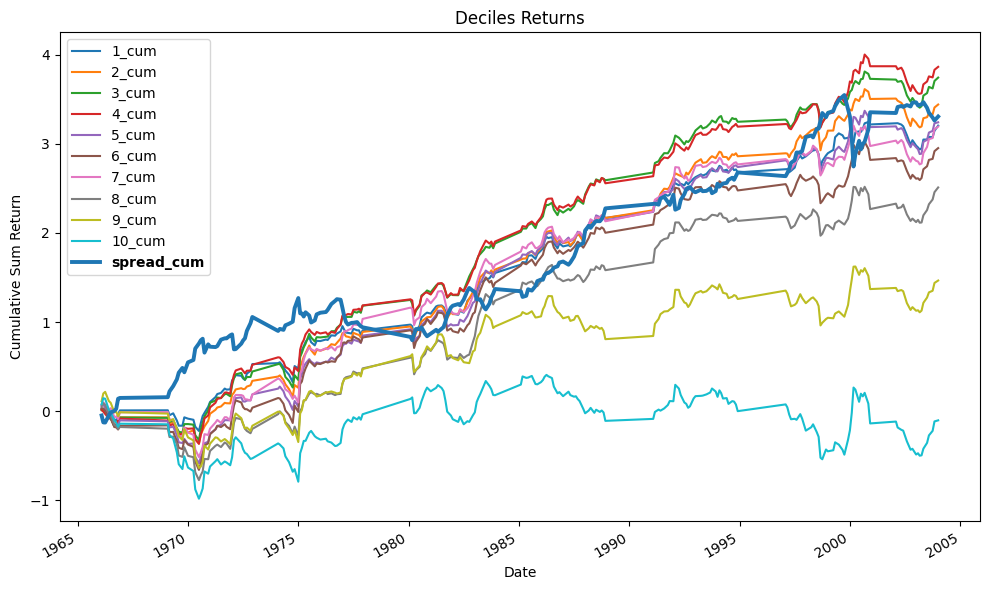

In [ ]:
bins = [1,2,3,4,5,6,7,8,9,10,"spread"]

# cumulative sums
for b in bins:
    ew[f"{b}_cum"] = ew[b].cumsum()

cum_cols = [f"{b}_cum" for b in bins]
spread_col = "spread_cum"
other_cols = [c for c in cum_cols if c != spread_col]

plt.figure(figsize=(10,6))
ax = ew[other_cols].plot(ax=plt.gca())                 # plot all except spread
ew[spread_col].plot(ax=ax, linewidth=2.8, zorder=5,    # re-plot spread thicker
                    label=spread_col)

ax.set_title("Deciles Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Sum Return")
leg = ax.legend(loc="best")

# make just the spread label bold in the legend
for txt in leg.get_texts():
    if txt.get_text() == spread_col:
        txt.set_fontweight("bold")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
#load in the fama french 5 factors
ff5=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5.csv')

# assume ew is your decile return DataFrame (monthly decimal returns, not cum)
# ensure dates align
ew.index = pd.to_datetime(ew.index)

# clean up FF5
ff = ff5.to_pandas().copy()
ff['date'] = pd.to_datetime(ff['date'].astype(str), format="%Y%m")  # convert 196307 → 1963-07
ff=ff[['RF','date']]

ew['date']=ew.index
ew=ew.reset_index(drop=True)
ew['date'] = ew['date'] - pd.offsets.MonthBegin(1)
ew=ew.merge(ff,on=['date'])
ew

,1,2,3,4,5,6,7,8,9,10,...,4_cum,5_cum,6_cum,7_cum,8_cum,9_cum,10_cum,spread_cum,date,RF
0,0.030759,0.022703,0.010642,0.016700,0.063215,0.032834,0.072502,0.051764,0.113168,0.078430,...,0.016700,0.063215,0.032834,0.072502,0.051764,0.113168,0.078430,-0.047672,1966-01-01,0.38
1,-0.009973,-0.015663,-0.004206,-0.020568,0.010617,-0.000917,0.027404,0.038383,0.085760,0.067522,...,-0.003868,0.073833,0.031916,0.099907,0.090146,0.198929,0.145952,-0.125167,1966-02-01,0.35
2,-0.007490,-0.010656,-0.017035,-0.026918,-0.034277,-0.028089,-0.023826,-0.021774,0.018415,-0.005619,...,-0.030786,0.039555,0.003828,0.076081,0.068373,0.217344,0.140334,-0.127038,1966-03-01,0.38
3,-0.044768,-0.049827,-0.054623,-0.051232,-0.091399,-0.081753,-0.057072,-0.088345,-0.103320,-0.124948,...,-0.082018,-0.051844,-0.077926,0.019008,-0.019973,0.114024,0.015386,-0.046858,1966-05-01,0.41
4,0.007513,-0.016351,-0.014323,0.006066,-0.006305,0.001270,0.014797,-0.024762,-0.018690,-0.024993,...,-0.075952,-0.058149,-0.076656,0.033805,-0.044734,0.095334,-0.009607,-0.014351,1966-06-01,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0.000575,0.011709,0.028057,0.032246,0.023159,0.034093,0.068162,0.059201,0.059628,0.064813,...,3.699692,3.045402,2.748867,2.965322,2.257362,1.275717,-0.355439,3.404062,2003-06-01,0.10
218,0.029404,0.044682,0.069834,0.057240,0.081214,0.071225,0.086774,0.064952,0.058064,0.084260,...,3.756931,3.126616,2.820092,3.052097,2.322314,1.333781,-0.271178,3.349205,2003-07-01,0.07
219,-0.003150,-0.012962,-0.017390,-0.011351,0.018970,0.011355,0.013161,0.053319,0.017665,0.050869,...,3.745580,3.145586,2.831447,3.065257,2.375632,1.351446,-0.220309,3.295186,2003-09-01,0.08
220,0.072517,0.076829,0.083668,0.085112,0.085594,0.086409,0.098749,0.082379,0.088061,0.105915,...,3.830692,3.231180,2.917856,3.164006,2.458012,1.439507,-0.114394,3.261788,2003-10-01,0.07


In [ ]:
# portfolios you want to evaluate
bins = [1,2,3,4,5,6,7,8,9,10,"spread"]

sharpes = {}

for b in bins:
    # excess return: portfolio - RF
    r_excess = ew[b] - ew["RF"]/100
    
    # monthly mean and std
    mean_m = r_excess.mean()
    std_m = r_excess.std(ddof=1)
    
    # monthly Sharpe
    sharpe_m = mean_m / std_m if std_m > 0 else np.nan
    
    # annualized Sharpe (multiply by sqrt(12))
    sharpe_a = sharpe_m * np.sqrt(12) if np.isfinite(sharpe_m) else np.nan
    
    sharpes[b] = {
        "Mean_monthly": mean_m,
        "Std_monthly": std_m,
        "Sharpe_monthly": sharpe_m,
        "Sharpe_annual": sharpe_a
    }

sharpe_df = pd.DataFrame(sharpes).T
print(sharpe_df.round(4))


        Mean_monthly  Std_monthly  Sharpe_monthly  Sharpe_annual
1             0.0096       0.0485          0.1976         0.6846
2             0.0107       0.0522          0.2040         0.7068
3             0.0120       0.0549          0.2189         0.7581
4             0.0126       0.0559          0.2246         0.7780
5             0.0098       0.0615          0.1587         0.5498
6             0.0085       0.0658          0.1284         0.4447
7             0.0095       0.0665          0.1435         0.4972
8             0.0065       0.0657          0.0984         0.3410
9             0.0018       0.0719          0.0245         0.0848
10           -0.0053       0.0790         -0.0672        -0.2327
spread        0.0100       0.0650          0.1545         0.5351


### Simple 5 Factor Reg

In [ ]:
import statsmodels.api as sm
import pandas as pd

# --- Clean up FF5 ---
ff = ff5.to_pandas().copy()
ff["date"] = pd.to_datetime(ff["date"].astype(str), format="%Y%m")  # YYYYMM → datetime
ff = ff.set_index("date")  # make date the index
ff = ff / 100.0   # convert % → decimals

# --- Align with ew returns ---
ew = ew.copy()
ew = ew.set_index("date")  # make sure ew also has datetime index
ew, ff = ew.align(ff, join="inner", axis=0)  # intersection of dates

# --- Factors ---
factors = ff[["Mkt-RF","SMB","HML","RMW","CMA"]]
rf = ff["RF"]

results = {}
for b in bins:
    y = ew[b] - rf  # excess portfolio return
    X = sm.add_constant(factors)
    model = sm.OLS(y, X).fit()
    results[b] = {
        "alpha": model.params["const"],
        "alpha_t": model.tvalues["const"],
        "R2": model.rsquared
    }
    print(f"=== Portfolio {b} ===")
    print(model.summary().tables[1])  # coefficients table
    print("\n")


=== Portfolio 1 ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.975      0.050    4.15e-06       0.004
Mkt-RF         1.0666      0.023     45.845      0.000       1.021       1.112
SMB            0.0536      0.030      1.774      0.077      -0.006       0.113
HML            0.2482      0.047      5.289      0.000       0.156       0.341
RMW            0.2221      0.040      5.515      0.000       0.143       0.301
CMA            0.1002      0.069      1.446      0.150      -0.036       0.237


=== Portfolio 2 ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      4.096      0.000       0.002       0.006
Mkt-RF         1.0515      0.022     48.189      0.000       1.009       1.095
SMB       

In [ ]:
import pandas as pd
import statsmodels.api as sm

# --- Factors ---
factors = ff[["Mkt-RF","SMB","HML","RMW","CMA"]]
rf = ff["RF"]

# store regression outputs
coefs = {}
tstats = {}

for b in bins:
    y = ew[b] - rf  # excess return
    X = sm.add_constant(factors)
    model = sm.OLS(y, X).fit()
    
    coefs[b] = model.params
    tstats[b] = model.tvalues

# convert dicts to DataFrames
coef_df = pd.DataFrame(coefs).reindex(["const","Mkt-RF","SMB","HML","RMW","CMA"])
tstat_df = pd.DataFrame(tstats).reindex(["const","Mkt-RF","SMB","HML","RMW","CMA"])

# round for display
coef_df = coef_df.round(4)
tstat_df = tstat_df.round(2)

# stack into a single table: coef with t-stat in parentheses
table = coef_df.astype(str) + " (" + tstat_df.astype(str) + ")"

table

,1,2,3,4,5,6,7,8,9,10,spread
const,0.002 (1.98),0.0038 (4.1),0.004 (3.7),0.0054 (5.15),0.002 (1.69),0.0003 (0.22),0.0009 (0.61),-0.0013 (-0.69),-0.0059 (-2.67),-0.0124 (-4.67),0.0094 (3.28)
Mkt-RF,1.0666 (45.84),1.0515 (48.19),1.059 (42.15),0.9995 (40.97),1.0394 (37.83),1.0591 (31.77),0.989 (27.68),0.9296 (21.28),0.9268 (17.79),0.9183 (14.85),0.1532 (2.29)
SMB,0.0536 (1.77),0.32 (11.3),0.5583 (17.12),0.6474 (20.45),0.8298 (23.27),0.9431 (21.8),1.1336 (24.45),1.0613 (18.72),1.214 (17.96),1.2706 (15.83),-1.2106 (-13.92)
HML,0.2482 (5.29),0.2448 (5.56),0.2109 (4.16),0.0849 (1.73),0.1381 (2.49),-0.003 (-0.04),0.2057 (2.85),0.1477 (1.68),0.2891 (2.75),0.0753 (0.6),0.1587 (1.17)
RMW,0.2221 (5.52),-0.0098 (-0.26),0.1073 (2.47),-0.0292 (-0.69),0.0009 (0.02),0.0223 (0.39),0.0882 (1.43),-0.006 (-0.08),-0.0265 (-0.29),-0.2989 (-2.79),0.5344 (4.61)
CMA,0.1002 (1.45),-0.0607 (-0.93),0.0707 (0.94),0.1068 (1.47),0.03 (0.37),0.1639 (1.65),0.0291 (0.27),0.0527 (0.41),-0.1704 (-1.1),0.0778 (0.42),0.0339 (0.17)


### Things to Do/Research

- Read the paper all the way 
- Test other ways to generate probablity of failure/bankruptcy (ML, DL, other regression?)
- Test other holding periods (monthly rebalance primarily)
- Test out of sample